In [64]:
import os
import pandas as pd

# Directories for checking empty files
NAIVE_DIR = "evaluation/rq4"              # For timebasic files
HORN_DIR = os.path.join("evaluation", "rq3", "random1000")  # For timehorn files

# -----------------------------
# Process execution_timebasic.csv
# -----------------------------
df_basic = pd.read_csv("execution_timebasic.csv")
df_basic = df_basic.rename(columns={"time_taken": "time_basic"})

def process_naive(row):
    """
    For each row, check if the corresponding file in NAIVE_DIR is empty.
    If empty or if the time is greater than 600, mark as "timeout".
    Otherwise, leave the numeric time.
    """
    # Build the expected filename: "crate_name-version"
    filename = f"{row['crate_name']}-{row['version']}"
    file_path = os.path.join(NAIVE_DIR, filename)
    
    # If file exists and is empty, mark as timeout
    if os.path.exists(file_path) and os.path.getsize(file_path) == 0:
        return "timeout"
    
    # Otherwise, check if the time exceeds 600
    try:
        t = float(row['time_basic'])
    except Exception:
        return row['time_basic']
    
    if t > 600:
        return "timeout"
    else:
        return t

df_basic["time_basic"] = df_basic.apply(process_naive, axis=1)

# Save the processed basic times to a new CSV file
df_basic.to_csv("execution_timebasic_timeout.csv", index=False)
print("Saved execution_timebasic_timeout.csv")

# -----------------------------
# Process execution_timeHorn.csv
# -----------------------------
df_horn = pd.read_csv("execution_timeHorn.csv")
df_horn = df_horn.rename(columns={"time_taken": "time_horn"})

def process_horn(row):
    """
    For each row, check if the corresponding file in HORN_DIR is empty.
    If empty or if the time is greater than 600, mark as "timeout".
    Otherwise, leave the numeric time.
    """
    # Build the expected filename: "crate_name-version"
    filename = f"{row['crate_name']}-{row['version']}"
    file_path = os.path.join(HORN_DIR, filename)
    
    # If file exists and is empty, mark as timeout
    if os.path.exists(file_path) and os.path.getsize(file_path) == 0:
        return "timeout"
    
    # Otherwise, check if the time exceeds 600
    try:
        t = float(row['time_horn'])
    except Exception:
        return row['time_horn']
    
    if t > 600:
        return "timeout"
    else:
        return t

df_horn["time_horn"] = df_horn.apply(process_horn, axis=1)

# Save the processed horn times to a new CSV file
df_horn.to_csv("execution_timeHorn_timeout.csv", index=False)
print("Saved execution_timeHorn_timeout.csv")


Saved execution_timebasic_timeout.csv
Saved execution_timeHorn_timeout.csv


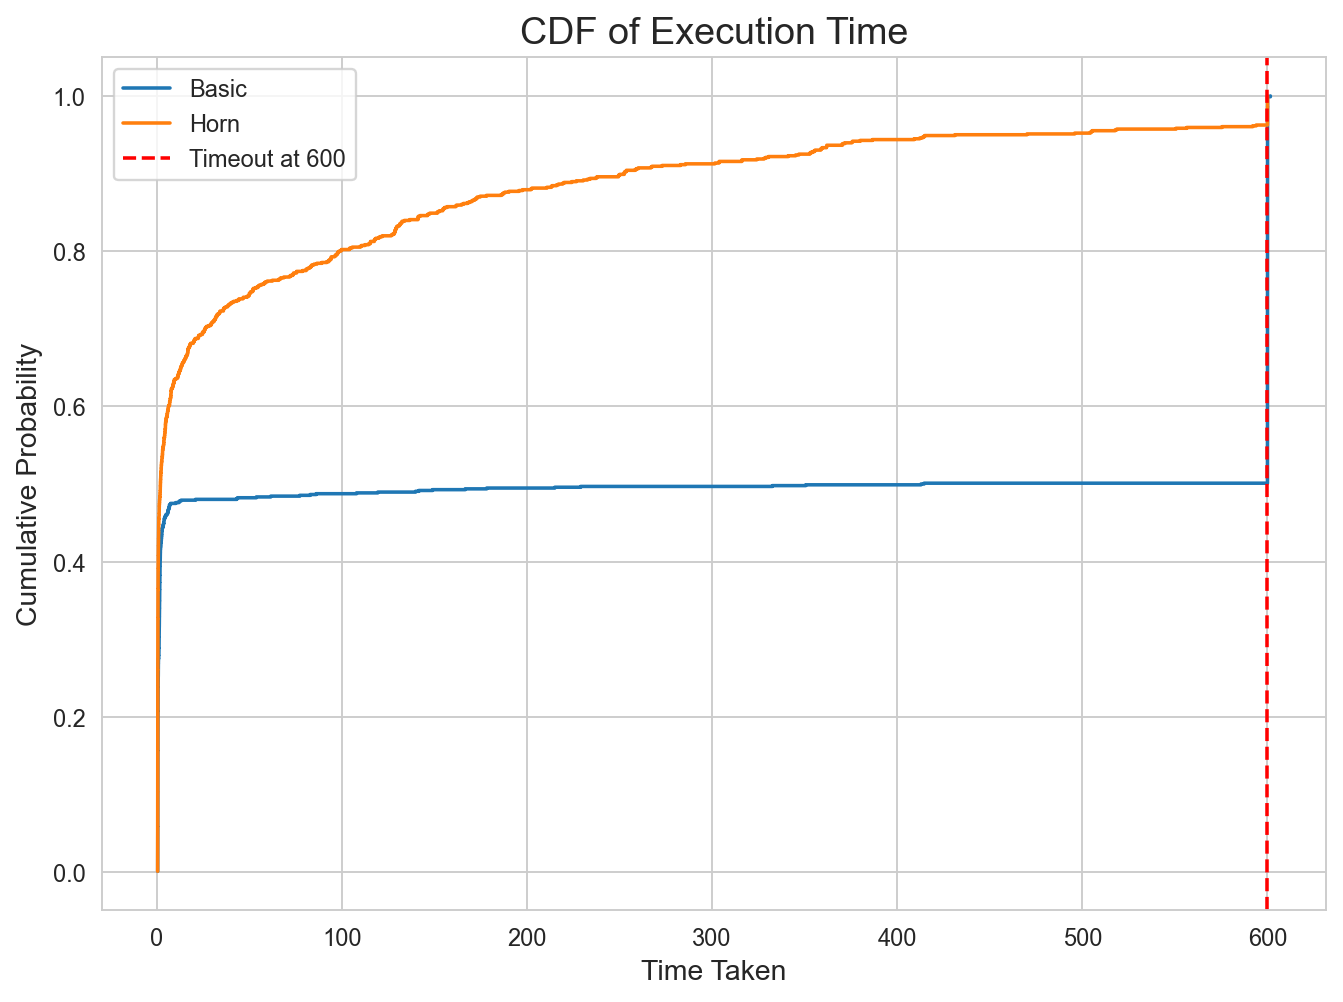

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read CSV files
df_basic = pd.read_csv("execution_timebasic.csv")
df_horn  = pd.read_csv("execution_timeHorn.csv")

# Sort the 'time_taken' values
times_basic = np.sort(df_basic['time_taken'])
times_horn  = np.sort(df_horn['time_taken'])

# Compute the CDF values
cdf_basic = np.arange(1, len(times_basic) + 1) / len(times_basic)
cdf_horn  = np.arange(1, len(times_horn) + 1) / len(times_horn)

# Create the plot
plt.figure(figsize=(8,6))
plt.step(times_basic, cdf_basic, label="Basic", where="post")
plt.step(times_horn, cdf_horn, label="Horn", where="post")

# Draw a vertical line at 600
plt.axvline(x=600, color='red', linestyle='--', label='Timeout at 600')

plt.xlabel("Time Taken")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Execution Time")
plt.grid(True)
plt.legend()
plt.tight_layout()

# plt.savefig("execution_time_cdf_timeout.pdf", bbox_inches="tight")
plt.show()


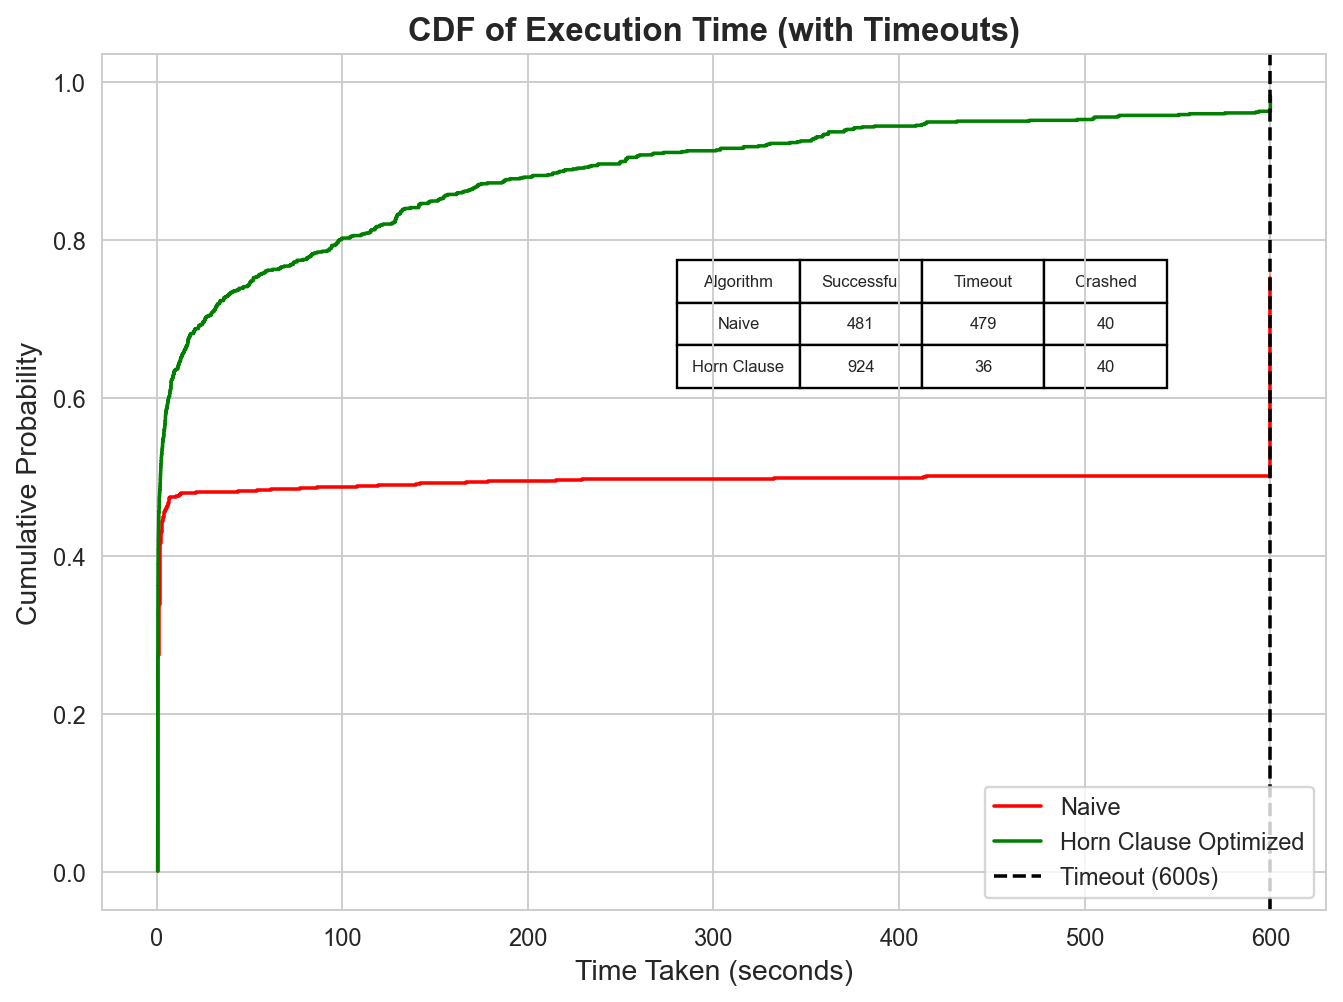

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Timeout threshold
timeout_threshold = 600

# 1. Read the new CSV files (as strings to preserve "timeout")
df_basic = pd.read_csv("execution_timebasic_timeout.csv", dtype=str)
df_horn  = pd.read_csv("execution_timeHorn_timeout.csv", dtype=str)

# 2. Create numeric columns that convert non-timeout values to float and assign NaN for "timeout"
df_basic["numeric_time"] = df_basic["time_taken"].apply(lambda x: float(x) if x.strip().lower() != "timeout" else np.nan)
df_horn["numeric_time"]  = df_horn["time_taken"].apply(lambda x: float(x) if x.strip().lower() != "timeout" else np.nan)

# 3. For plotting, convert times: 
#    Replace NaN (which represent timeouts) with the timeout_threshold (600)
times_basic = np.sort(df_basic["numeric_time"].fillna(timeout_threshold).values)
times_horn  = np.sort(df_horn["numeric_time"].fillna(timeout_threshold).values)

# 4. Compute the CDFs
cdf_basic = np.arange(1, len(times_basic) + 1) / len(times_basic)
cdf_horn  = np.arange(1, len(times_horn)  + 1) / len(times_horn)

# 5. Outcome counts
# Count as "successful" if the numeric time exists and is less than timeout_threshold
success_basic = np.sum(df_basic["numeric_time"] < timeout_threshold)
# Count as "timeout" if the original string is "timeout" or numeric time is >= timeout_threshold
timeout_basic = np.sum((df_basic["time_taken"].str.lower() == "timeout") | (df_basic["numeric_time"] >= timeout_threshold))
crashed_basic = 40  
success_horn = np.sum(df_horn["numeric_time"] < timeout_threshold)
timeout_horn = np.sum((df_horn["time_taken"].str.lower() == "timeout") | (df_horn["numeric_time"] >= timeout_threshold))
crashed_horn = 40  

# 6. Create the figure and axes
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,6))

# 7. Plot the CDF lines (using "steps-post" draw style)
sns.lineplot(x=times_basic, y=cdf_basic, drawstyle="steps-post", color="red",
             label="Naive", ax=ax)
sns.lineplot(x=times_horn, y=cdf_horn, drawstyle="steps-post", color="green",
             label="Horn Clause Optimized", ax=ax)

# Add a vertical line for the timeout threshold
ax.axvline(timeout_threshold, color="black", linestyle="--",
           label=f"Timeout ({timeout_threshold}s)")

ax.set_xlabel("Time Taken (seconds)", fontsize=12)
ax.set_ylabel("Cumulative Probability", fontsize=12)
ax.set_title("CDF of Execution Time (with Timeouts)", fontsize=14, fontweight="bold")
ax.legend(loc="lower right")

# 8. Create the table data with outcome counts
table_data = [
    ["Algorithm",   "Successful", "Timeout", "Crashed"],
    ["Naive",       success_basic, timeout_basic, crashed_basic],
    ["Horn Clause", success_horn,  timeout_horn,  crashed_horn]
]

the_table = ax.table(
    cellText=table_data,
    loc="upper right",   # adjust the bbox as needed
    cellLoc="center",
    bbox=[0.47, 0.61, 0.4, 0.15]  # [left, bottom, width, height]
)
the_table.scale(0.6, 1)
the_table.set_fontsize(9)

plt.tight_layout()
plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/cdf_new.pdf", bbox_inches="tight")
plt.show()


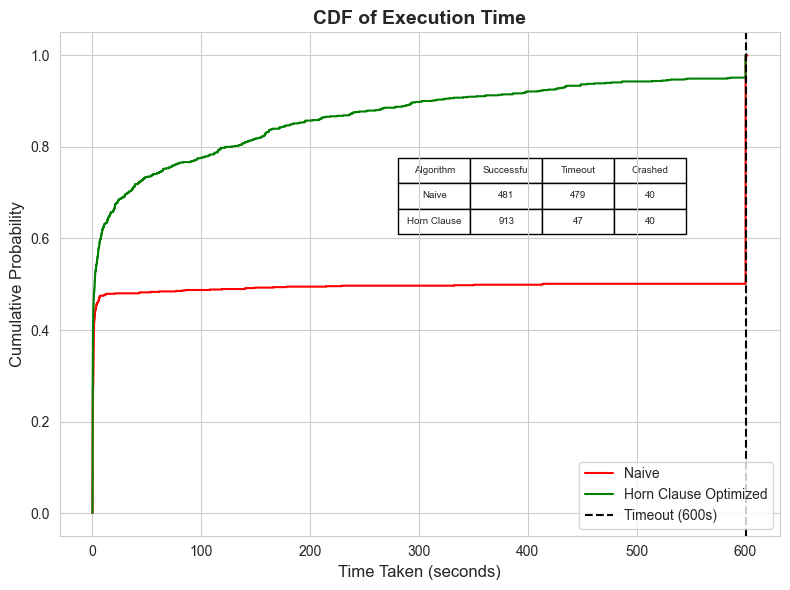

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Read your CSV files
df_basic = pd.read_csv("execution_timebasic.csv")
df_horn  = pd.read_csv("execution_timeHorn.csv")

# 2. Sort execution times
times_basic = np.sort(df_basic["time_taken"].values)
times_horn  = np.sort(df_horn["time_taken"].values)

# 3. Compute the CDF
cdf_basic = np.arange(1, len(times_basic) + 1) / len(times_basic)
cdf_horn  = np.arange(1, len(times_horn)  + 1) / len(times_horn)

# 4. Timeout threshold
timeout_threshold = 600

# 5. Outcome counts
success_basic = np.sum(times_basic < timeout_threshold)
timeout_basic = np.sum(times_basic >= timeout_threshold)
crashed_basic = 40  # or any crash data you have

success_horn = np.sum(times_horn < timeout_threshold)
timeout_horn = np.sum(times_horn >= timeout_threshold)
crashed_horn = 40   # or any crash data you have

# 6. Create the figure and axes FIRST
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,6))

# 7. Plot the CDF lines
sns.lineplot(x=times_basic, y=cdf_basic, drawstyle="steps-post", color="red",
             label="Naive", ax=ax)
sns.lineplot(x=times_horn, y=cdf_horn, drawstyle="steps-post", color="green",
             label="Horn Clause Optimized", ax=ax)

# Add a vertical line for timeout
ax.axvline(timeout_threshold, color="black", linestyle="--",
           label=f"Timeout ({timeout_threshold}s)")

ax.set_xlabel("Time Taken (seconds)", fontsize=12)
ax.set_ylabel("Cumulative Probability", fontsize=12)
ax.set_title("CDF of Execution Time", fontsize=14, fontweight="bold")

# 8. Place the legend
ax.legend(loc="lower right")

# 9. Create the table data using your live values
table_data = [
    ["Algorithm",   "Successful", "Timeout", "Crashed"],
    ["Naive",       success_basic, timeout_basic, crashed_basic],
    ["Horn Clause", success_horn,  timeout_horn,  crashed_horn]
]

# 10. Add the table to the SAME Axes (ax). 
the_table = ax.table(
    cellText=table_data,
    loc="upper right",   # place in upper-right corner of the Axes
    cellLoc="center", 
    bbox=[0.47, 0.6, 0.4, 0.15],  # [left, bottom, width, height]
)

# Make the table a bit bigger or smaller as needed
the_table.scale(0.6, 1)
the_table.set_fontsize(9)


# Optionally hide top/right spines if they interfere
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/cdf.pdf", bbox_inches="tight")
plt.show()


JSON decode error in file serde-big-array-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 203)
JSON decode error in file markdown-0.3.0.json: Expecting property name enclosed in double quotes: line 11 column 1 (char 203)
JSON decode error in file mio-extras-2.0.6.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pipeline-0.5.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file glsl-layout-derive-0.4.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file lzma-sys-0.1.20.json: Expecting property name enclosed in double quotes: line 32 column 1 (char 601)
JSON decode error in file fail-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pickledb-0.5.1.json: Expecting property name enclosed in double quotes: line

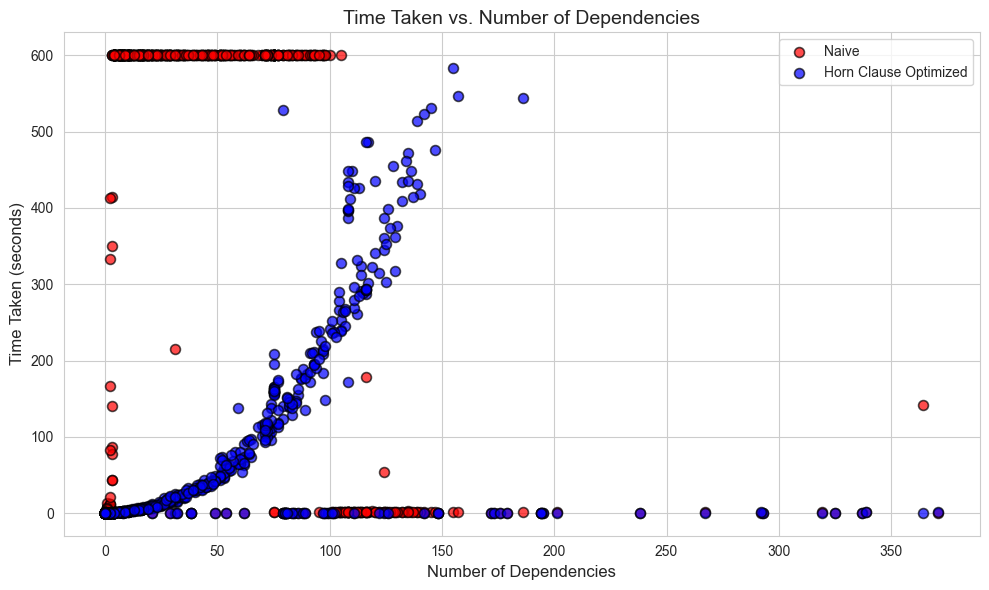

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Parse JSON files for dependency counts
# -----------------------------
CACHE_DIR = "logs/cache"  # Adjust path if needed
rows = []
failed_files = []  # List to hold names of JSON files that failed to parse

for filename in os.listdir(CACHE_DIR):
    if not filename.endswith(".json"):
        continue  # Skip non-JSON files
    path = os.path.join(CACHE_DIR, filename)
    
    # Assume filename format: "crate_name-version.json"
    base = filename[:-5]  # Remove ".json"
    if "-" in base:
        crate_name, crate_version = base.rsplit("-", 1)
    else:
        crate_name = base
        crate_version = "0.0.0"
    
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"JSON decode error in file {filename}: {e}")
        failed_files.append(filename)
        continue  # Skip this file
    
    # Get the dependency list and count them
    deps = data.get("dependencies", [])
    dep_count = len(deps)
    
    rows.append({
        "crate_name": crate_name,
        "version": crate_version,
        "dependency_count": dep_count
    })

df_deps = pd.DataFrame(rows)
print("Dependency counts extracted:")
print(df_deps.head())
if failed_files:
    print("The following files failed to parse and were skipped:")
    for f in failed_files:
        print(f)

# -----------------------------
# 2. Read timing CSV files for two algorithms
# -----------------------------
df_basic = pd.read_csv("execution_timebasic.csv")
df_basic = df_basic.rename(columns={"time_taken": "time_basic"})
# Expected columns: [crate_name, version, time_basic]

df_horn = pd.read_csv("execution_timeHorn.csv")
df_horn = df_horn.rename(columns={"time_taken": "time_horn"})
# Expected columns: [crate_name, version, time_horn]

# -----------------------------
# 3. Merge timing data and dependency counts
# -----------------------------
# Merge the two timing CSVs on crate_name and version (outer join to include all available data)
df_times = pd.merge(df_basic, df_horn, on=["crate_name", "version"], how="outer")
# Merge with dependency count data
df_merged = pd.merge(df_times, df_deps, on=["crate_name", "version"], how="left")

# Save combined CSV for future reference
df_merged.to_csv("data_with_deps_and_times.csv", index=False)
print("Merged data saved to data_with_deps_and_times.csv")
print(df_merged.head())

# -----------------------------
# 4. Remove outliers
# -----------------------------
# Remove rows where time_basic or time_horn exceeds the 95th percentile (if not NaN)
threshold_basic = df_merged["time_basic"].quantile(0.95)
threshold_horn  = df_merged["time_horn"].quantile(0.95)

df_filtered = df_merged[
    ((df_merged["time_basic"] <= threshold_basic) | (df_merged["time_basic"].isna())) &
    ((df_merged["time_horn"]  <= threshold_horn)  | (df_merged["time_horn"].isna()))
]
print("Data after outlier removal:")
print(df_filtered.head())

# -----------------------------
# 5. Plot a scatter chart: Dependency count vs. Time Taken (filtered data)
# -----------------------------
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10,6))

# Scatter plot for Basic approach in red
ax.scatter(
    df_filtered["dependency_count"],
    df_filtered["time_basic"],
    color="red",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Naive"
)

# Scatter plot for Horn approach in blue
ax.scatter(
    df_filtered["dependency_count"],
    df_filtered["time_horn"],
    color="blue",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Horn Clause Optimized"
)

ax.set_xlabel("Number of Dependencies", fontsize=12)
ax.set_ylabel("Time Taken (seconds)", fontsize=12)
ax.set_title("Time Taken vs. Number of Dependencies", fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter.pdf", bbox_inches="tight")
plt.show()


In [ ]:
import pandas as pd

df_deps = pd.read_csv("data_with_deps_and_times.csv")
# Filter for crates with 200 or more dependencies
high_dep_crates = df_deps[df_deps["dependency_count"] >= 200]
print(high_dep_crates[["crate_name", "version", "dependency_count"]])


Crates with 200+ dependencies:
                  crate_name  version  dependency_count
91              bellhop-demo    0.2.1             201.0
124          bevy_ldtk_asset    0.6.4             214.0
221               deathframe    0.5.1             293.0
388                 gweiyser    0.1.4             227.0
443                     iroh   0.34.0             292.0
444                 iroh-api    0.2.0             210.0
448               iroh-blobs   0.34.0             319.0
451                 iroh-cli   0.28.1             364.0
452          iroh-dns-server   0.34.0             238.0
453                iroh-docs   0.34.0             325.0
454              iroh-doctor   0.33.0             337.0
455               iroh-embed    0.2.0             311.0
495                 migrator    0.1.0             206.0
577                     neo3    0.1.9             267.0
622           photon-indexer   0.50.0             626.0
652                   picahq    0.1.1             318.0
770              

In [27]:
threshold_basic = df_merged["time_basic"].quantile(0.95)
print("95th percentile for Basic:", threshold_basic)


95th percentile for Basic: 600.057812491816


In [28]:
df_merged[df_merged["dependency_count"] > 100].sort_values("dependency_count", ascending=False)
df_merged

,crate_name,version,time_basic,time_horn,dependency_count
0,agave-librapay-api,0.1.0,0.809032,0.665015,0.0
1,agave-loader-v4-program,0.1.0,0.693730,0.660973,0.0
2,agave-local-cluster,0.1.0,0.712956,0.723543,0.0
3,agave-logger,0.1.0,0.684772,0.604826,0.0
4,agave-lualoader,0.1.0,0.701251,0.665164,0.0
...,...,...,...,...,...
955,yew-virtualized,0.2.0,600.011749,118.720100,72.0
956,yew-websocket,1.21.0,600.033975,150.806487,81.0
957,yew-webtransport,0.21.1,600.018104,134.860121,77.0
958,yew_assets,0.1.2,600.026078,108.523697,71.0


JSON decode error in file serde-big-array-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 203)
JSON decode error in file markdown-0.3.0.json: Expecting property name enclosed in double quotes: line 11 column 1 (char 203)
JSON decode error in file mio-extras-2.0.6.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pipeline-0.5.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file glsl-layout-derive-0.4.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file lzma-sys-0.1.20.json: Expecting property name enclosed in double quotes: line 32 column 1 (char 601)
JSON decode error in file fail-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pickledb-0.5.1.json: Expecting property name enclosed in double quotes: line

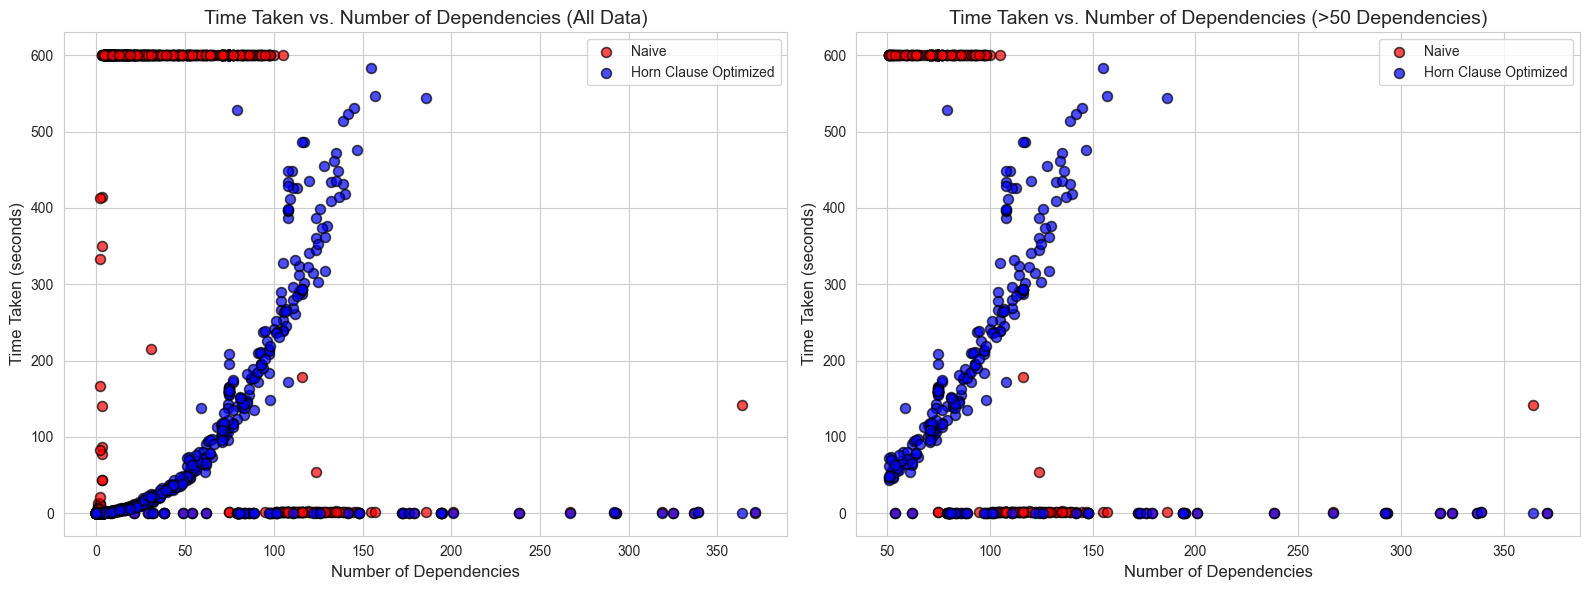

High Dependency Projects (>50 dependencies):
          crate_name  version  dependency_count  time_basic  time_horn
835    solana-tokens    2.2.3             371.0    0.835535   1.040119
451         iroh-cli   0.28.1             364.0  141.683157   0.939598
813   solana-install  1.18.26             339.0    1.514938   1.193974
454      iroh-doctor   0.33.0             337.0    0.765522   0.824348
453        iroh-docs   0.34.0             325.0    0.774653   0.716393
448       iroh-blobs   0.34.0             319.0    1.040699   0.991342
221       deathframe    0.5.1             293.0    0.930642   0.818624
443             iroh   0.34.0             292.0    0.984011   1.031215
577             neo3    0.1.9             267.0    1.255725   0.933331
452  iroh-dns-server   0.34.0             238.0    0.938010   0.832625


In [43]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Parse JSON files for dependency counts
# -----------------------------
CACHE_DIR = "logs/cache"  # Adjust path if needed
rows = []
failed_files = []  # List to hold names of JSON files that failed to parse

for filename in os.listdir(CACHE_DIR):
    if not filename.endswith(".json"):
        continue  # Skip non-JSON files
    path = os.path.join(CACHE_DIR, filename)
    
    # Assume filename format: "crate_name-version.json"
    base = filename[:-5]  # Remove ".json"
    if "-" in base:
        crate_name, crate_version = base.rsplit("-", 1)
    else:
        crate_name = base
        crate_version = "0.0.0"
    
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"JSON decode error in file {filename}: {e}")
        failed_files.append(filename)
        continue  # Skip this file
    
    # Get the dependency list and count them
    deps = data.get("dependencies", [])
    dep_count = len(deps)
    
    rows.append({
        "crate_name": crate_name,
        "version": crate_version,
        "dependency_count": dep_count
    })

df_deps = pd.DataFrame(rows)

# -----------------------------
# 2. Read timing CSV files for two algorithms
# -----------------------------
df_basic = pd.read_csv("execution_timebasic.csv")
df_basic = df_basic.rename(columns={"time_taken": "time_basic"})

df_horn = pd.read_csv("execution_timeHorn.csv")
df_horn = df_horn.rename(columns={"time_taken": "time_horn"})

# -----------------------------
# 3. Merge timing data and dependency counts
# -----------------------------
df_times = pd.merge(df_basic, df_horn, on=["crate_name", "version"], how="outer")
df_merged = pd.merge(df_times, df_deps, on=["crate_name", "version"], how="left")

# -----------------------------
# 4. Remove outliers and filter for higher dependencies
# -----------------------------
threshold_basic = df_merged["time_basic"].quantile(0.95)
threshold_horn = df_merged["time_horn"].quantile(0.95)

df_filtered = df_merged[
    ((df_merged["time_basic"] <= threshold_basic) | (df_merged["time_basic"].isna())) &
    ((df_merged["time_horn"] <= threshold_horn) | (df_merged["time_horn"].isna()))
]

# Filter for projects with more than 50 dependencies
df_high_deps = df_filtered[df_filtered["dependency_count"] > 50]

# -----------------------------
# 5. Plot scatter charts
# -----------------------------
sns.set_style("whitegrid")

# Plot for all data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# All data scatter plot
ax1.scatter(
    df_filtered["dependency_count"],
    df_filtered["time_basic"],
    color="red",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Naive"
)
ax1.scatter(
    df_filtered["dependency_count"],
    df_filtered["time_horn"],
    color="blue",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Horn Clause Optimized"
)
ax1.set_xlabel("Number of Dependencies", fontsize=12)
ax1.set_ylabel("Time Taken (seconds)", fontsize=12)
ax1.set_title("Time Taken vs. Number of Dependencies (All Data)", fontsize=14)
ax1.legend()

# High dependencies scatter plot
ax2.scatter(
    df_high_deps["dependency_count"],
    df_high_deps["time_basic"],
    color="red",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Naive"
)
ax2.scatter(
    df_high_deps["dependency_count"],
    df_high_deps["time_horn"],
    color="blue",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Horn Clause Optimized"
)
ax2.set_xlabel("Number of Dependencies", fontsize=12)
ax2.set_ylabel("Time Taken (seconds)", fontsize=12)
ax2.set_title("Time Taken vs. Number of Dependencies (>50 Dependencies)", fontsize=14)
ax2.legend()

plt.tight_layout()
# plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter_high_deps.pdf", bbox_inches="tight")
plt.show()

# Print some statistics about high dependency projects
print("High Dependency Projects (>50 dependencies):")
print(df_high_deps[["crate_name", "version", "dependency_count", "time_basic", "time_horn"]].sort_values("dependency_count", ascending=False).head(10))

In [53]:
import pandas as pd
import numpy as np

# Assuming you have the merged dataframe from previous code
# Filter for high dependency projects
df_high_deps = df_merged[df_merged["dependency_count"] > 50]

# Identify projects with blue points but missing red points
blue_only_projects = df_high_deps[
    (df_high_deps["time_horn"].notna()) & 
    (df_high_deps["time_basic"].isna())
]

print("Projects with Horn Clause times but no Naive approach times:")
print(blue_only_projects[["crate_name", "version", "dependency_count", "time_horn"]])

# Print a summary of high dependency projects
print("\nSummary of High Dependency Projects:")
summary = df_high_deps.groupby(pd.cut(df_high_deps["dependency_count"], bins=[50, 100, 200, 300, np.inf])).agg({
    "crate_name": "count",
    "time_basic": ["mean", "count"],
    "time_horn": ["mean", "count"]
})
print(summary)

Projects with Horn Clause times but no Naive approach times:
Empty DataFrame
Columns: [crate_name, version, dependency_count, time_horn]
Index: []

Summary of High Dependency Projects:
                 crate_name  time_basic         time_horn      
                      count        mean count        mean count
dependency_count                                               
(50.0, 100.0]           154  518.310438   154   91.243815   154
(100.0, 200.0]          118   11.616861   118  316.576857   118
(200.0, 300.0]           16    2.336459    16  412.756208    16
(300.0, inf]             16   53.078552    16  337.888263    16


/var/folders/lq/4jp2ndl57996typyw791t0x00000gn/T/ipykernel_28898/687212045.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_high_deps.groupby(pd.cut(df_high_deps["dependency_count"], bins=[50, 100, 200, 300, np.inf])).agg({


JSON decode error in file serde-big-array-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 203)
JSON decode error in file markdown-0.3.0.json: Expecting property name enclosed in double quotes: line 11 column 1 (char 203)
JSON decode error in file mio-extras-2.0.6.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pipeline-0.5.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file glsl-layout-derive-0.4.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file lzma-sys-0.1.20.json: Expecting property name enclosed in double quotes: line 32 column 1 (char 601)
JSON decode error in file fail-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pickledb-0.5.1.json: Expecting property name enclosed in double quotes: line

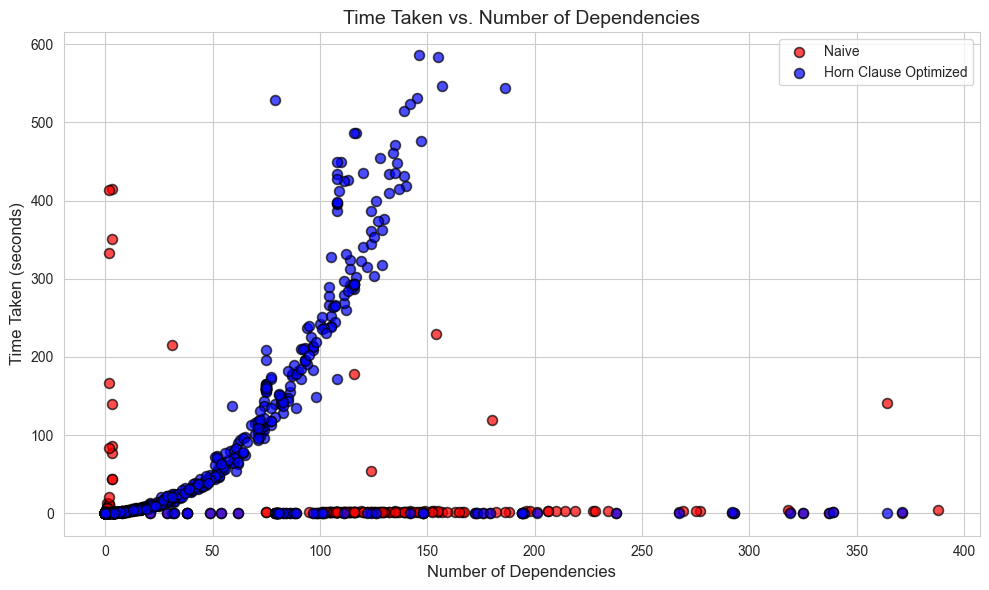

In [58]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Parse JSON files for dependency counts
# -----------------------------
CACHE_DIR = "logs/cache"  # Adjust path if needed
rows = []
failed_files = []  # List to hold names of JSON files that failed to parse

for filename in os.listdir(CACHE_DIR):
    if not filename.endswith(".json"):
        continue  # Skip non-JSON files
    path = os.path.join(CACHE_DIR, filename)
    
    # Assume filename format: "crate_name-version.json"
    base = filename[:-5]  # Remove ".json"
    if "-" in base:
        crate_name, crate_version = base.rsplit("-", 1)
    else:
        crate_name = base
        crate_version = "0.0.0"
    
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"JSON decode error in file {filename}: {e}")
        failed_files.append(filename)
        continue  # Skip this file
    
    # Get the dependency list and count them
    deps = data.get("dependencies", [])
    dep_count = len(deps)
    
    rows.append({
        "crate_name": crate_name,
        "version": crate_version,
        "dependency_count": dep_count
    })

df_deps = pd.DataFrame(rows)
print("Dependency counts extracted:")
print(df_deps.head())
if failed_files:
    print("The following files failed to parse and were skipped:")
    for f in failed_files:
        print(f)

# -----------------------------
# 2. Read timing CSV files for two algorithms
# -----------------------------
df_basic = pd.read_csv("execution_timebasic.csv")
df_basic = df_basic.rename(columns={"time_taken": "time_basic"})
# Expected columns: [crate_name, version, time_basic]

df_horn = pd.read_csv("execution_timeHorn.csv")
df_horn = df_horn.rename(columns={"time_taken": "time_horn"})
# Expected columns: [crate_name, version, time_horn]

# -----------------------------
# 3. Merge timing data and dependency counts
# -----------------------------
df_times = pd.merge(df_basic, df_horn, on=["crate_name", "version"], how="outer")
df_merged = pd.merge(df_times, df_deps, on=["crate_name", "version"], how="left")

# Save combined CSV for future reference
df_merged.to_csv("data_with_deps_and_times.csv", index=False)
print("Merged data saved to data_with_deps_and_times.csv")
print(df_merged.head())

# -----------------------------
# 4. Filter data for plotting
# -----------------------------
# First, remove crates with more than 400 dependencies
# df_filtered = df_merged[df_merged["dependency_count"] <= 400]

# For Naive approach: only plot points where time_basic is 600 or less
df_naive_plot = df_filtered[df_filtered["time_basic"] <= 600]


# For Horn Clause Optimized approach: only plot points where time_horn is 600 or less
df_horn_plot = df_filtered[df_filtered["time_horn"] <= 600]

print("Naive data for plotting:")
print(df_naive_plot.head())
print("Horn Clause Optimized data for plotting:")
print(df_horn_plot.head())

# -----------------------------
# 5. Plot a scatter chart: Dependency count vs. Time Taken
# -----------------------------
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for Naive approach (red)
ax.scatter(
    df_naive_plot["dependency_count"],
    df_naive_plot["time_basic"],
    color="red",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Naive"
)

# Scatter plot for Horn Clause Optimized approach (blue)
ax.scatter(
    df_horn_plot["dependency_count"],
    df_horn_plot["time_horn"],
    color="blue",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Horn Clause Optimized"
)

ax.set_xlabel("Number of Dependencies", fontsize=12)
ax.set_ylabel("Time Taken (seconds)", fontsize=12)
ax.set_title("Time Taken vs. Number of Dependencies", fontsize=14)
ax.legend()

plt.tight_layout()
# plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter.pdf", bbox_inches="tight")
plt.show()


JSON decode error in file serde-big-array-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 203)
JSON decode error in file markdown-0.3.0.json: Expecting property name enclosed in double quotes: line 11 column 1 (char 203)
JSON decode error in file mio-extras-2.0.6.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pipeline-0.5.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file glsl-layout-derive-0.4.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file lzma-sys-0.1.20.json: Expecting property name enclosed in double quotes: line 32 column 1 (char 601)
JSON decode error in file fail-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pickledb-0.5.1.json: Expecting property name enclosed in double quotes: line

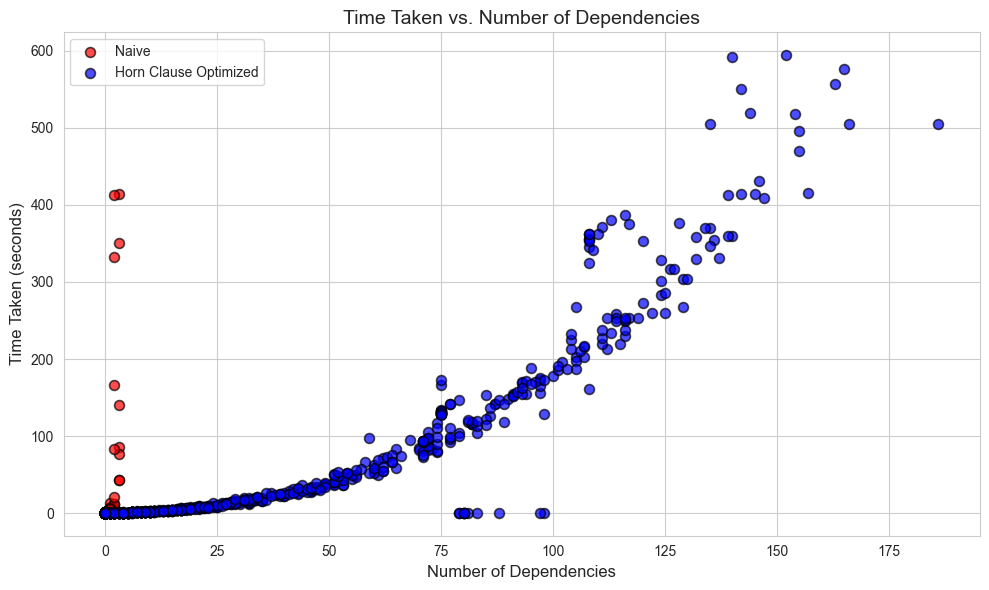

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CACHE_DIR = "logs/cache"
rows = []
failed_files = []  

for filename in os.listdir(CACHE_DIR):
    if not filename.endswith(".json"):
        continue  # Skip non-JSON files
    path = os.path.join(CACHE_DIR, filename)
    
    base = filename[:-5]  # Remove ".json"
    if "-" in base:
        crate_name, crate_version = base.rsplit("-", 1)
    else:
        crate_name = base
        crate_version = "0.0.0"
    
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"JSON decode error in file {filename}: {e}")
        failed_files.append(filename)
        continue  # Skip this file
    
    # Get the dependency list and count them
    deps = data.get("dependencies", [])
    dep_count = len(deps)
    
    rows.append({
        "crate_name": crate_name,
        "version": crate_version,
        "dependency_count": dep_count
    })

df_deps = pd.DataFrame(rows)
print("Dependency counts extracted:")
print(df_deps.head())
if failed_files:
    print("The following files failed to parse and were skipped:")
    for f in failed_files:
        print(f)

df_basic = pd.read_csv("execution_timebasic_timeout.csv", dtype=str)
df_basic = df_basic.rename(columns={"time_taken": "time_basic"})

df_horn = pd.read_csv("execution_timeHorn_timeout.csv", dtype=str)
df_horn = df_horn.rename(columns={"time_taken": "time_horn"})

df_times = pd.merge(df_basic, df_horn, on=["crate_name", "version"], how="outer")
df_merged = pd.merge(df_times, df_deps, on=["crate_name", "version"], how="left")

df_merged.to_csv("data_with_deps_and_times_new.csv", index=False)
print("Merged data saved to data_with_deps_and_times_new.csv")
print(df_merged.head())

df_merged["time_basic_numeric"] = pd.to_numeric(df_merged["time_basic"], errors='coerce')
df_merged["time_horn_numeric"]  = pd.to_numeric(df_merged["time_horn"], errors='coerce')

df_filtered = df_merged[df_merged["dependency_count"] <= 400]

df_plot_basic = df_filtered[df_filtered["time_basic_numeric"].notna()].copy()
df_plot_horn  = df_filtered[df_filtered["time_horn_numeric"].notna()].copy()

NAIVE_DIR = "evaluation/rq4"  # Directory for Naive approach files
HORN_DIR = os.path.join("evaluation", "rq3", "random1000")  # Directory for Horn Clause files

def file_has_more_than_one_line(directory, crate_name, version):
    filename = f"{crate_name}-{version}"
    file_path = os.path.join(directory, filename)
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lines = f.readlines()
        return len(lines) > 1
    # If file does not exist, we assume it's valid for plotting
    return True

df_plot_basic = df_plot_basic[df_plot_basic.apply(
    lambda row: file_has_more_than_one_line(NAIVE_DIR, row["crate_name"], row["version"]), axis=1
)]

df_plot_horn = df_plot_horn[df_plot_horn.apply(
    lambda row: file_has_more_than_one_line(HORN_DIR, row["crate_name"], row["version"]), axis=1
)]

print("Filtered data for Naive plotting:")
print(df_plot_basic.head())
print("Filtered data for Horn Clause plotting:")
print(df_plot_horn.head())

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,6))

# Scatter plot for Naive approach (red)
ax.scatter(
    df_plot_basic["dependency_count"],
    df_plot_basic["time_basic_numeric"],
    color="red",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Naive"
)

# Scatter plot for Horn Clause Optimized approach (blue)
ax.scatter(
    df_plot_horn["dependency_count"],
    df_plot_horn["time_horn_numeric"],
    color="blue",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Horn Clause Optimized"
)

ax.set_xlabel("Number of Dependencies", fontsize=12)
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_ylabel("Time Taken (seconds)", fontsize=12)
ax.set_title("Time Taken vs. Number of Dependencies", fontsize=14)
ax.legend()

# log_x = np.log(df_plot_basic["dependency_count"])
# log_y = np.log(df_plot_basic["time_horn_numeric"])
# m, b = np.polyfit(log_x, log_y, 1)
# ax.plot(df_plot_basic["dependency_count"], np.exp(m*log_x + b), color="red", linestyle="--")

plt.tight_layout()
plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter.pdf", bbox_inches="tight")
plt.show()


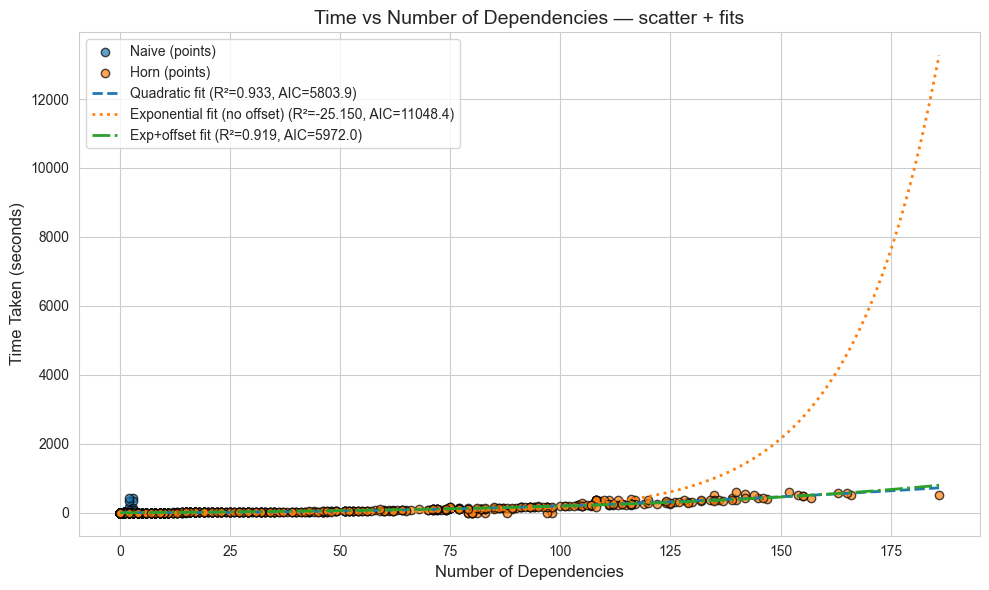

Fit quality (higher R² is better, lower AIC is better):
Quadratic             R²=0.933  AIC=5803.9
Exponential (no offset)  R²=-25.150  AIC=11048.4
Exp+offset            R²=0.919  AIC=5972.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- Use your existing Axes if present; otherwise make a new one ---
if plt.get_fignums():
    ax = plt.gca()
else:
    fig, ax = plt.subplots(figsize=(10, 6))

# === 1) Scatter points (both series) ===
# Naive (red) points
ax.scatter(
    df_plot_basic["dependency_count"].values,
    df_plot_basic["time_basic_numeric"].values,
    label="Naive (points)",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.0
)

# Horn (blue) points
x_blue = df_plot_horn["dependency_count"].values
y_blue = df_plot_horn["time_horn_numeric"].values
ax.scatter(
    x_blue, y_blue,
    label="Horn (points)",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.0
)

# Clean data for fitting
m = np.isfinite(x_blue) & np.isfinite(y_blue)
x_fit = x_blue[m]
y_fit = y_blue[m]

# Helper: metrics
def r2(y, yhat):
    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

def aic(y, yhat, k):
    n = y.size
    rss = np.sum((y - yhat) ** 2)
    return n*np.log(rss/n) + 2*k if n > k and rss > 0 else np.nan

# X range for smooth lines
x_line = np.linspace(x_fit.min(), x_fit.max(), 300)

# === 2) Quadratic fit: y = ax^2 + bx + c ===
q_coeffs = np.polyfit(x_fit, y_fit, 2)
q_poly = np.poly1d(q_coeffs)
yq_line = q_poly(x_line)
yq_pred = q_poly(x_fit)
q_r2 = r2(y_fit, yq_pred)
q_aic = aic(y_fit, yq_pred, k=3)
ax.plot(x_line, yq_line, linestyle="--", linewidth=2,
        label=f"Quadratic fit (R²={q_r2:.3f}, AIC={q_aic:.1f})")

# === 3) Exponential (no offset): y = A * exp(Bx) ===
mask_pos = y_fit > 0
if mask_pos.sum() >= 2:
    B, lnA = np.polyfit(x_fit[mask_pos], np.log(y_fit[mask_pos]), 1)
    A = np.exp(lnA)
    ye_line = A * np.exp(B * x_line)
    ye_pred = A * np.exp(B * x_fit[mask_pos])
    e_r2 = r2(y_fit[mask_pos], ye_pred)
    e_aic = aic(y_fit[mask_pos], ye_pred, k=2)
    ax.plot(x_line, ye_line, linestyle=":", linewidth=2,
            label=f"Exponential fit (no offset) (R²={e_r2:.3f}, AIC={e_aic:.1f})")
else:
    e_r2 = e_aic = np.nan

# === 4) Exponential with offset: y = A * exp(Bx) + C (optional, needs SciPy) ===
try:
    from scipy.optimize import curve_fit
    def exp_with_offset(x, A, B, C):
        return A * np.exp(B * x) + C

    # Initial guess + loose bounds
    p0 = [max(y_fit), 0.01, min(y_fit)]
    bounds = ([0.0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])

    popt, _ = curve_fit(exp_with_offset, x_fit, y_fit, p0=p0, bounds=bounds, maxfev=20000)
    A2, B2, C2 = popt
    yeo_line = exp_with_offset(x_line, A2, B2, C2)
    yeo_pred = exp_with_offset(x_fit, A2, B2, C2)
    eo_r2 = r2(y_fit, yeo_pred)
    eo_aic = aic(y_fit, yeo_pred, k=3)
    ax.plot(x_line, yeo_line, linestyle="-.", linewidth=2,
            label=f"Exp+offset fit (R²={eo_r2:.3f}, AIC={eo_aic:.1f})")
except Exception as err:
    eo_r2 = eo_aic = np.nan
    print("Exp+offset fit skipped:", err)

# === Styling ===
ax.set_xlabel("Number of Dependencies", fontsize=12)
ax.set_ylabel("Time Taken (seconds)", fontsize=12)
ax.set_title("Time vs Number of Dependencies — scatter + fits", fontsize=14)
ax.legend()
ax.relim(); ax.autoscale_view()
plt.tight_layout()
plt.show()

# === Quick textual verdict ===
fits = {
    "Quadratic": {"R2": q_r2, "AIC": q_aic},
    "Exponential (no offset)": {"R2": e_r2, "AIC": e_aic},
    "Exp+offset": {"R2": eo_r2, "AIC": eo_aic}
}
print("Fit quality (higher R² is better, lower AIC is better):")
for name, m_ in fits.items():
    print(f"{name:20s}  R²={m_['R2']:.3f}  AIC={m_['AIC']:.1f}")


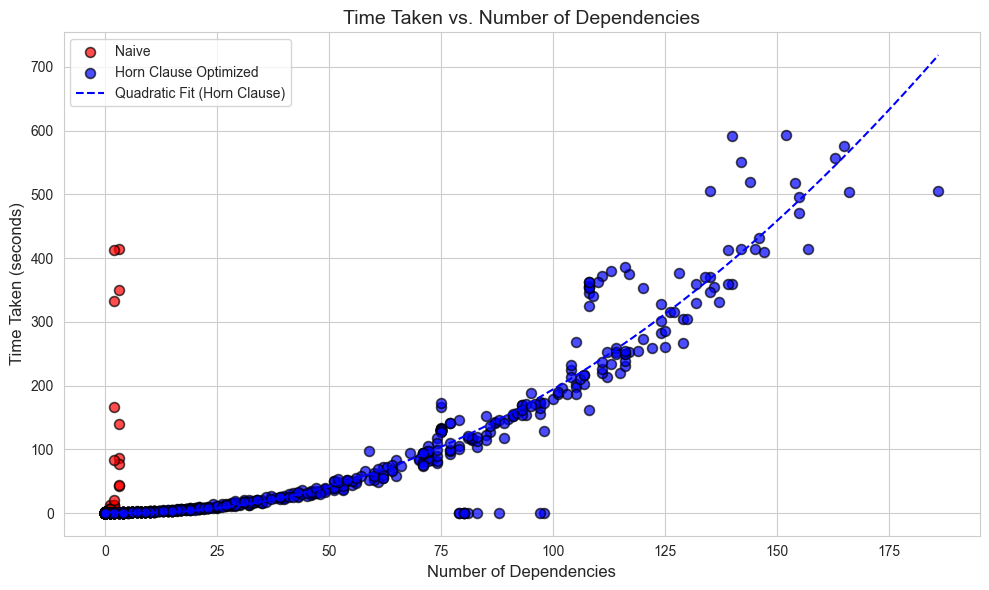

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data: df_plot_basic (Naive) and df_plot_horn (Horn Clause)
# with columns: "dependency_count" and "time_basic_numeric" or "time_horn_numeric"

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# --- Plot Naive approach in red ---
ax.scatter(
    df_plot_basic["dependency_count"],
    df_plot_basic["time_basic_numeric"],
    color="red",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Naive"
)

# --- Plot Horn Clause approach in blue ---
ax.scatter(
    df_plot_horn["dependency_count"],
    df_plot_horn["time_horn_numeric"],
    color="blue",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Horn Clause Optimized"
)

# --- Quadratic fit for the Horn Clause data ---
x_blue = df_plot_horn["dependency_count"].values
y_blue = df_plot_horn["time_horn_numeric"].values

# Fit a 2nd-degree polynomial: time = a*x^2 + b*x + c
coeffs = np.polyfit(x_blue, y_blue, 2)  # degree=2 for quadratic
p = np.poly1d(coeffs)

# Create a smooth range of x-values and compute the corresponding y-values
x_line = np.linspace(x_blue.min(), x_blue.max(), 200)
y_line = p(x_line)

# Plot the quadratic fit line in dashed blue
ax.plot(x_line, y_line, color="blue", linestyle="--", label="Quadratic Fit (Horn Clause)")

ax.set_xlabel("Number of Dependencies", fontsize=12)
ax.set_ylabel("Time Taken (seconds)", fontsize=12)
ax.set_title("Time Taken vs. Number of Dependencies", fontsize=14)
ax.legend()

plt.tight_layout()
# plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter_quadratic.pdf", bbox_inches="tight")
plt.show()


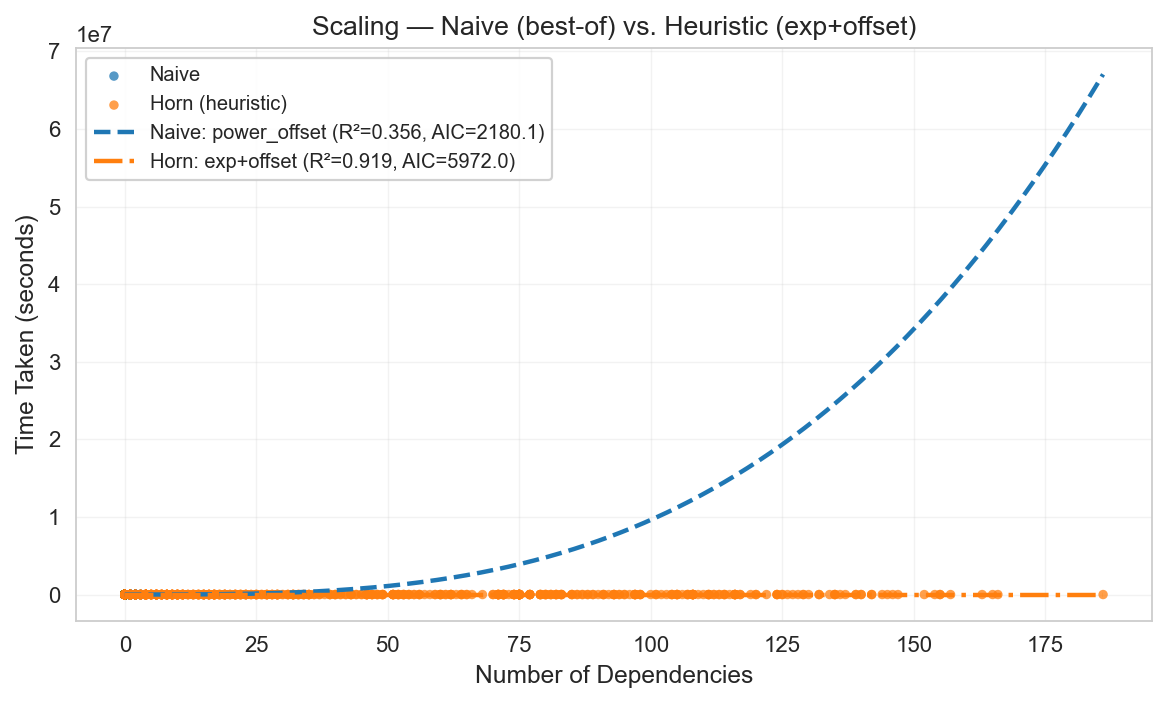

Naive best model: power_offset
  params: [5.33, 3.128, 0.3732]
  R²=0.356, AIC=2180.1
Horn exp+offset: A=63.27, B=0.01405, C=-69.89, R²=0.919, AIC=5972.0


In [5]:
# --- Naive: model selection (AIC) + Horn: exp-with-offset ---
# Requires: numpy, matplotlib, scipy

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --------- Pull arrays from your prepared dataframes ----------
# Horn (heuristic)
xh = df_plot_horn["dependency_count"].to_numpy(dtype=float)
yh = df_plot_horn["time_horn_numeric"].to_numpy(dtype=float)
m = np.isfinite(xh) & np.isfinite(yh)
xh, yh = xh[m], yh[m]

# Naive
xn = df_plot_basic["dependency_count"].to_numpy(dtype=float)
yn = df_plot_basic["time_basic_numeric"].to_numpy(dtype=float)
m = np.isfinite(xn) & np.isfinite(yn)
xn, yn = xn[m], yn[m]

# --------- Utility metrics ----------
def r2_score(y, yhat):
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

def aic_score(y, yhat, k):
    n = y.size
    rss = np.sum((y - yhat)**2)
    return n*np.log(rss/n) + 2*k if (n > k and rss > 0) else np.nan

# --------- Horn model: y = A * exp(Bx) + C ----------
def exp_with_offset(x, A, B, C):
    return A * np.exp(B * x) + C

def fit_exp_offset(x, y):
    order = np.argsort(x); x, y = x[order], y[order]
    spread = np.ptp(y) if np.isfinite(y).any() else 1.0
    y_min = float(np.nanmin(y)) if np.isfinite(y).any() else 0.0
    y_max = float(np.nanmax(y)) if np.isfinite(y).any() else 1.0
    p0 = [max(1.0, y_max), 0.01, max(0.0, y_min - 0.1*spread)]
    bounds = ([0.0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
    popt, _ = curve_fit(exp_with_offset, x, y, p0=p0, bounds=bounds, maxfev=20000)
    yhat = exp_with_offset(x, *popt)
    r2 = r2_score(y, yhat)
    aic = aic_score(y, yhat, k=3)
    return popt, (x, yhat), r2, aic

# --------- Naive candidate models ----------
def linear(x, a, b):           # k=2
    return a*x + b

def log_model(x, a, b):        # k=2; safe at x=0 via log(x+1)
    return a*np.log(x + 1.0) + b

def power_offset(x, a, b, c):  # k=3; y = a * x^b + c, x>=0
    return a * np.power(np.maximum(x, 0.0), b) + c

def cubic(x, a, b, c, d):      # k=4
    return ((a*x + b)*x + c)*x + d

def fit_with_curve(func, x, y, p0, bounds, k):
    order = np.argsort(x); x, y = x[order], y[order]
    popt, _ = curve_fit(func, x, y, p0=p0, bounds=bounds, maxfev=20000)
    yhat = func(x, *popt)
    return {
        "name": func.__name__,
        "popt": popt,
        "x_sorted": x,
        "yhat": yhat,
        "r2": r2_score(y, yhat),
        "aic": aic_score(y, yhat, k),
        "k": k,
        "func": func
    }

# Reasonable initial guesses/bounds for Naive
spread_n = np.ptp(yn) if np.isfinite(yn).any() else 1.0
ymin_n = float(np.nanmin(yn)) if np.isfinite(yn).any() else 0.0
ymax_n = float(np.nanmax(yn)) if np.isfinite(yn).any() else 1.0

candidates = []

# Linear
candidates.append(
    fit_with_curve(
        linear, xn, yn,
        p0=[(ymax_n - ymin_n) / max(1.0, np.ptp(xn)), ymin_n],
        bounds=([-np.inf, -np.inf], [np.inf, np.inf]),
        k=2
    )
)

# Logarithmic
candidates.append(
    fit_with_curve(
        log_model, xn, yn,
        p0=[spread_n, ymin_n],
        bounds=([-np.inf, -np.inf], [np.inf, np.inf]),
        k=2
    )
)

# Power-law + offset
candidates.append(
    fit_with_curve(
        power_offset, xn, yn,
        p0=[max(1.0, ymax_n), 1.0, max(0.0, ymin_n - 0.1*spread_n)],
        bounds=([0.0, 0.0, -np.inf], [np.inf, 5.0, np.inf]),  # exponent in [0,5] as a sanity range
        k=3
    )
)

# Cubic
# Use np.polyfit for stable init then curve_fit to standardize metrics
coeffs = np.polyfit(xn, yn, 3)
p0_cubic = [coeffs[0], coeffs[1], coeffs[2], coeffs[3]]
candidates.append(
    fit_with_curve(
        cubic, xn, yn,
        p0=p0_cubic,
        bounds=([-np.inf]*4, [np.inf]*4),
        k=4
    )
)

# Pick best by lowest AIC (fallback to highest R2 if all AIC nan)
valid = [c for c in candidates if np.isfinite(c["aic"])]
if valid:
    best_naive = min(valid, key=lambda c: c["aic"])
else:
    best_naive = max(candidates, key=lambda c: c["r2"])

# Fit Horn
(hA, hB, hC), (xh_sorted, yh_fit), r2_h, aic_h = fit_exp_offset(xh, yh)

# --------- Prepare smooth lines ----------
xmin = min(xh.min(), xn.min())
xmax = max(xh.max(), xn.max())
x_line = np.linspace(xmin, xmax, 600)

naive_func = best_naive["func"]
naive_line = naive_func(x_line, *best_naive["popt"])
horn_line  = exp_with_offset(x_line, hA, hB, hC)

# --------- Plot (publication-friendly) ----------
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "pdf.fonttype": 42,  # editable text in vector editors
    "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(7.4, 4.5))

# Scatter
ax.scatter(xn, yn, s=18, alpha=0.75, label="Naive", edgecolors="none")
ax.scatter(xh, yh, s=18, alpha=0.75, label="Horn (heuristic)", edgecolors="none")

# Fit lines
ax.plot(x_line, naive_line, linewidth=2, linestyle="--",
        label=f"Naive: {best_naive['name']} (R²={best_naive['r2']:.3f}, AIC={best_naive['aic']:.1f})")
ax.plot(x_line, horn_line,  linewidth=2, linestyle="-.",
        label=f"Horn: exp+offset (R²={r2_h:.3f}, AIC={aic_h:.1f})")

# Labels / cosmetics
ax.set_xlabel("Number of Dependencies")
ax.set_ylabel("Time Taken (seconds)")
ax.set_title("Scaling — Naive (best-of) vs. Heuristic (exp+offset)")
ax.grid(True, which="major", linewidth=0.6, alpha=0.25)
ax.minorticks_on()
ax.legend(frameon=True, fancybox=True, framealpha=0.9, loc="upper left")

fig.tight_layout()
fig.savefig("scaling_naive_best_vs_horn_expOffset.pdf", bbox_inches="tight")
fig.savefig("scaling_naive_best_vs_horn_expOffset.png", bbox_inches="tight")
plt.show()

print("Naive best model:", best_naive["name"])
print("  params:", [float(f"{p:.4g}") for p in best_naive["popt"]])
print(f"  R²={best_naive['r2']:.3f}, AIC={best_naive['aic']:.1f}")
print(f"Horn exp+offset: A={hA:.4g}, B={hB:.4g}, C={hC:.4g}, R²={r2_h:.3f}, AIC={aic_h:.1f}")


/var/folders/lq/4jp2ndl57996typyw791t0x00000gn/T/ipykernel_55902/643335548.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


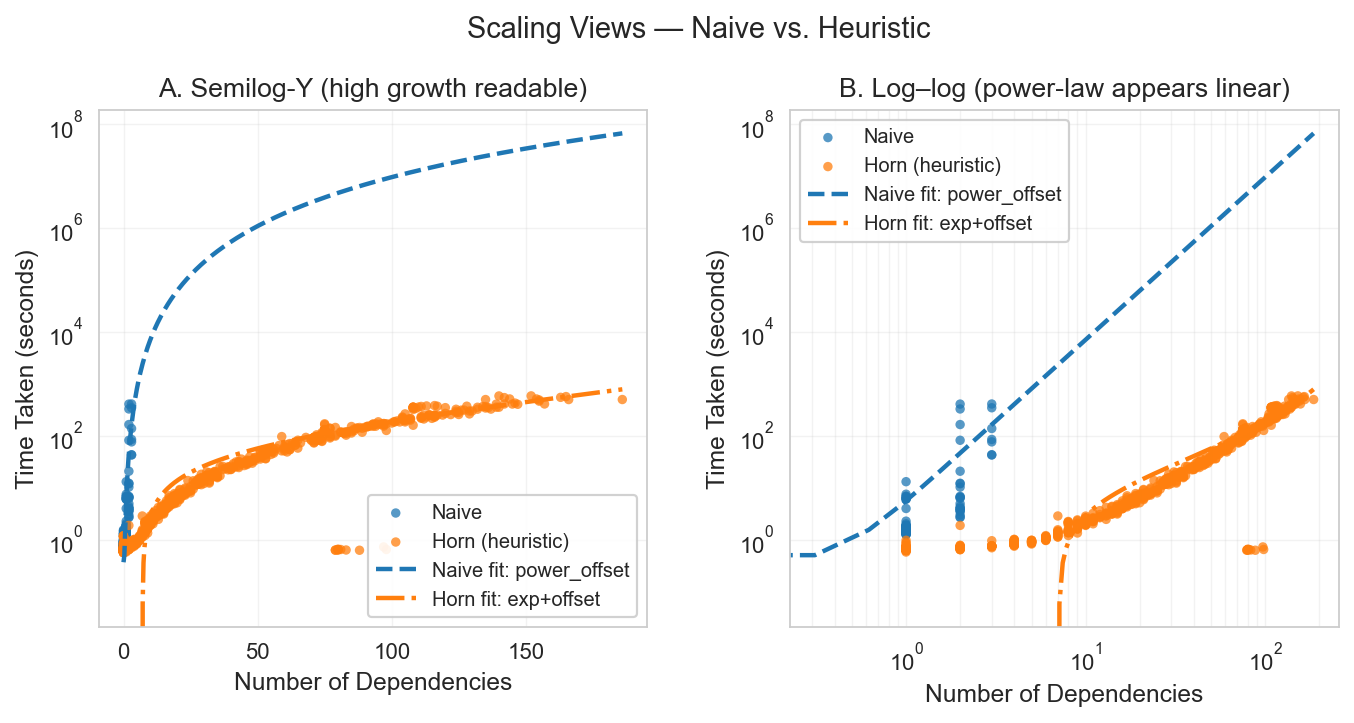

In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Reuse variables from your previous step:
# - xn, yn  (Naive scatter)
# - xh, yh  (Horn scatter)
# - naive_func, best_naive["popt"] (chosen Naive model)
# - hA, hB, hC (Horn exp+offset params)
# If you don't have them yet, run the model-selection block we used earlier.

def exp_with_offset(x, A, B, C):
    return A * np.exp(B * x) + C

# Smooth x range for lines
xmin = min(xh.min(), xn.min())
xmax = max(xh.max(), xn.max())
x_line = np.linspace(xmin, xmax, 600)

naive_line = naive_func(x_line, *best_naive["popt"])
horn_line  = exp_with_offset(x_line, hA, hB, hC)

# ---- Matplotlib styling (publication-friendly) ----
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

fig = plt.figure(figsize=(10, 4.2))
gs = fig.add_gridspec(1, 2, wspace=0.26)

# ---------- Panel A: Semilog-Y ----------
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(xn, yn, s=18, alpha=0.75, label="Naive", edgecolors="none")
ax1.scatter(xh, yh, s=18, alpha=0.75, label="Horn (heuristic)", edgecolors="none")

ax1.plot(x_line, naive_line, linewidth=2, linestyle="--",
         label=f"Naive fit: {best_naive['name']}")
ax1.plot(x_line, horn_line, linewidth=2, linestyle="-.",
         label="Horn fit: exp+offset")

ax1.set_yscale("log")
ax1.set_xlabel("Number of Dependencies")
ax1.set_ylabel("Time Taken (seconds)")
ax1.set_title("A. Semilog-Y (high growth readable)")
ax1.grid(True, which="both", linewidth=0.6, alpha=0.25)
ax1.legend(frameon=True, fancybox=True, framealpha=0.9)

# ---------- Panel B: Log–log ----------
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(xn, yn, s=18, alpha=0.75, label="Naive", edgecolors="none")
ax2.scatter(xh, yh, s=18, alpha=0.75, label="Horn (heuristic)", edgecolors="none")

ax2.plot(x_line, naive_line, linewidth=2, linestyle="--",
         label=f"Naive fit: {best_naive['name']}")
ax2.plot(x_line, horn_line, linewidth=2, linestyle="-.",
         label="Horn fit: exp+offset")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Number of Dependencies")
ax2.set_ylabel("Time Taken (seconds)")
ax2.set_title("B. Log–log (power-law appears linear)")
ax2.grid(True, which="both", linewidth=0.6, alpha=0.25)
ax2.legend(frameon=True, fancybox=True, framealpha=0.9)

fig.suptitle("Scaling Views — Naive vs. Heuristic", y=1.02, fontsize=13)
fig.tight_layout()
# fig.savefig("scaling_semilogy_and_loglog.pdf", bbox_inches="tight")
# fig.savefig("scaling_semilogy_and_loglog.png", bbox_inches="tight")
plt.show()


/var/folders/lq/4jp2ndl57996typyw791t0x00000gn/T/ipykernel_55902/3335181867.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


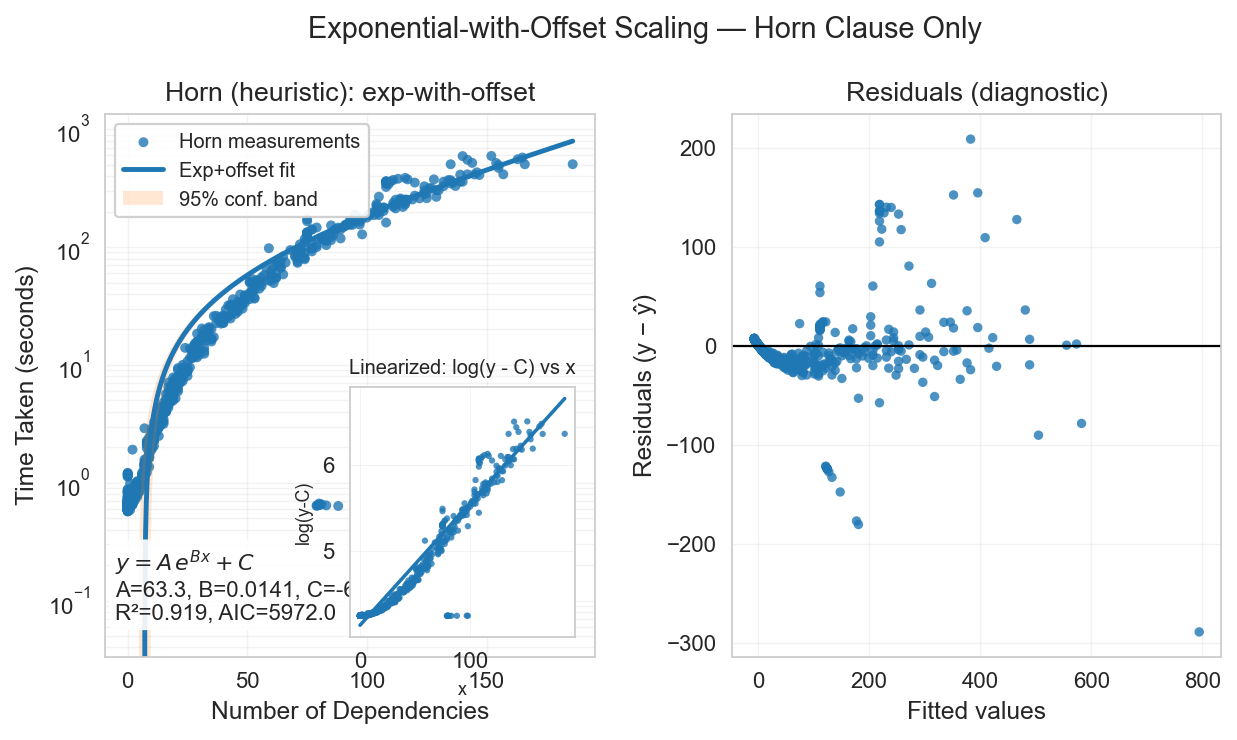

Horn exp+offset params: A=63.2721, B=0.0140548, C=-69.8937
R²=0.919  AIC=5972.0


In [7]:
# --- Horn-only, exp-with-offset, with confidence band + residuals panel ---
# Expects: df_plot_horn with columns "dependency_count" and "time_horn_numeric"

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1) Data ----------------------------------------------------------------------
x = df_plot_horn["dependency_count"].to_numpy(dtype=float)
y = df_plot_horn["time_horn_numeric"].to_numpy(dtype=float)
m = np.isfinite(x) & np.isfinite(y) & (y > 0)
x, y = x[m], y[m]
order = np.argsort(x); x, y = x[order], y[order]

# 2) Model + fit ---------------------------------------------------------------
def exp_with_offset(x, A, B, C):              # y = A * exp(Bx) + C
    return A * np.exp(B * x) + C

# sensible initial guesses (NumPy 2.0 safe)
spread = np.ptp(y) if np.isfinite(y).any() else 1.0
ymin   = float(np.nanmin(y)) if np.isfinite(y).any() else 0.0
ymax   = float(np.nanmax(y)) if np.isfinite(y).any() else 1.0
p0     = [max(1.0, ymax), 0.01, max(0.0, ymin - 0.1*spread)]
bounds = ([0.0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])

popt, pcov = curve_fit(exp_with_offset, x, y, p0=p0, bounds=bounds, maxfev=20000)
A, B, C = popt
yhat = exp_with_offset(x, *popt)

# metrics
ss_res = np.sum((y - yhat)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2  = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
n, k = y.size, 3
aic = n*np.log(ss_res/n) + 2*k if (n > k and ss_res > 0) else np.nan

# 3) Confidence band for the curve --------------------------------------------
# Delta method: var(f(x)) ≈ J Σ Jᵀ where J = [∂f/∂A, ∂f/∂B, ∂f/∂C]
x_line = np.linspace(x.min(), x.max(), 600)
expBx  = np.exp(B * x_line)
J = np.vstack([expBx, A * x_line * expBx, np.ones_like(x_line)]).T  # shape (m,3)
# (m,3) @ (3,3) @ (3,m) -> (m,m); but we only need diagonal:
var_curve = np.einsum("ij,jk,ik->i", J, pcov, J)
se_curve  = np.sqrt(np.maximum(0.0, var_curve))
y_line    = exp_with_offset(x_line, A, B, C)
ci_low    = y_line - 1.96 * se_curve
ci_high   = y_line + 1.96 * se_curve

# 4) Plot ----------------------------------------------------------------------
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "pdf.fonttype": 42, "ps.fonttype": 42,  # editable text in vector editors
})

fig = plt.figure(figsize=(9.0, 4.4))
gs  = fig.add_gridspec(1, 2, wspace=0.28)

# Left: main relationship (semilog-Y so growth is clear but still readable)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(x, y, s=20, alpha=0.8, edgecolors="none", label="Horn measurements")

ax.plot(x_line, y_line, lw=2.2, ls="-", label="Exp+offset fit")
ax.fill_between(x_line, ci_low, ci_high, alpha=0.18, linewidth=0, label="95% conf. band")

ax.set_yscale("log")  # exposes exponential behavior nicely
ax.set_xlabel("Number of Dependencies")
ax.set_ylabel("Time Taken (seconds)")
ax.set_title("Horn (heuristic): exp-with-offset")
ax.grid(True, which="both", lw=0.6, alpha=0.25)
ax.legend(frameon=True, fancybox=True, framealpha=0.92, loc="upper left")

# Small inset: linearized view log(y - C) vs x (should be ~straight)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax_in = inset_axes(ax, width="46%", height="46%", loc="lower right", borderpad=1.0)
mask_lin = (y - C) > 0
ax_in.scatter(x[mask_lin], np.log(y[mask_lin] - C), s=8, alpha=0.8, edgecolors="none")
ax_in.plot(x_line, np.log(np.maximum(y_line - C, 1e-12)), lw=1.6)
ax_in.set_title("Linearized: log(y - C) vs x", fontsize=9)
ax_in.set_xlabel("x", fontsize=8); ax_in.set_ylabel("log(y-C)", fontsize=8)
ax_in.grid(True, lw=0.4, alpha=0.25)

# Right: residuals vs fitted
axr = fig.add_subplot(gs[0, 1])
resid = y - yhat
axr.scatter(yhat, resid, s=18, alpha=0.8, edgecolors="none")
axr.axhline(0.0, color="k", lw=1.0)
axr.set_xlabel("Fitted values")
axr.set_ylabel("Residuals (y − ŷ)")
axr.set_title("Residuals (diagnostic)")
axr.grid(True, lw=0.6, alpha=0.25)

# Annotation with fitted equation + metrics (kept compact)
eq = r"$y = A\,e^{Bx} + C$"
ax.text(0.02, 0.06, f"{eq}\nA={A:.3g}, B={B:.3g}, C={C:.3g}\nR²={r2:.3f}, AIC={aic:.1f}",
        transform=ax.transAxes, ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.9, lw=0.5))

fig.suptitle("Exponential-with-Offset Scaling — Horn Clause Only", y=1.02, fontsize=13)
fig.tight_layout()

# fig.savefig("horn_exp_offset_only.pdf", bbox_inches="tight")
# fig.savefig("horn_exp_offset_only.png", bbox_inches="tight")
plt.show()

print(f"Horn exp+offset params: A={A:.6g}, B={B:.6g}, C={C:.6g}")
print(f"R²={r2:.3f}  AIC={aic:.1f}")


/var/folders/lq/4jp2ndl57996typyw791t0x00000gn/T/ipykernel_55902/2597684153.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


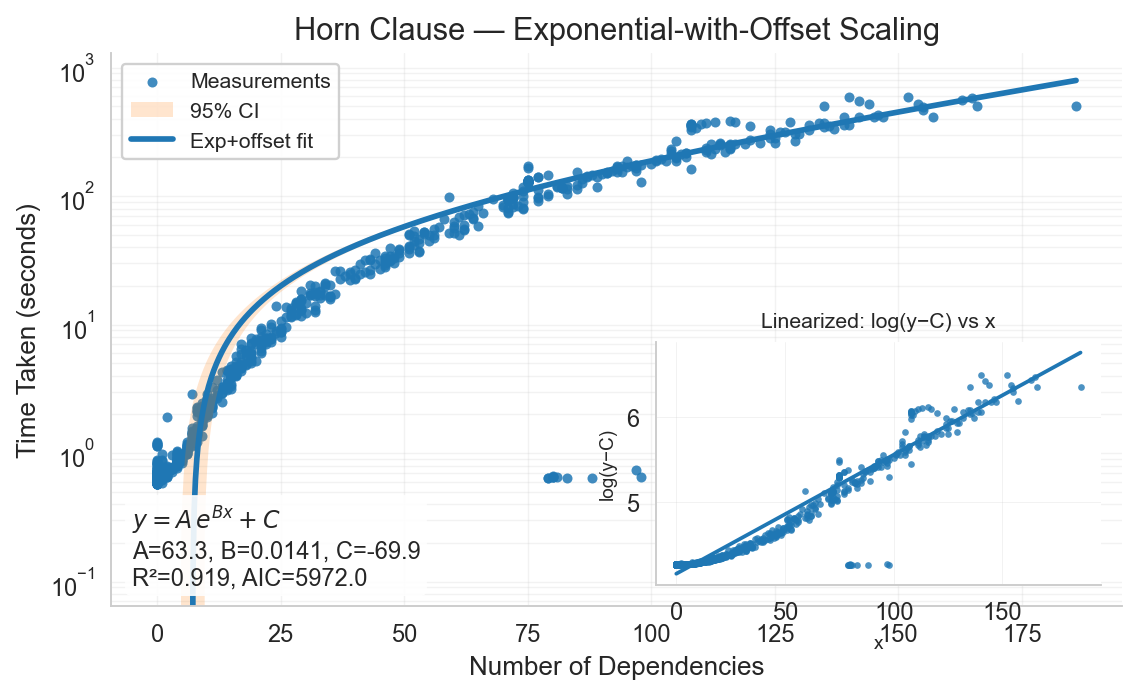

Params: A=63.2721, B=0.0140548, C=-69.8937 | R²=0.919, AIC=5972.0


In [8]:
# Pretty, publication-ready Horn-only plot with exp+offset fit
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- Data ---
x = df_plot_horn["dependency_count"].to_numpy(float)
y = df_plot_horn["time_horn_numeric"].to_numpy(float)
m = np.isfinite(x) & np.isfinite(y) & (y > 0)
x, y = x[m], y[m]
order = np.argsort(x)
x, y = x[order], y[order]

# --- Model & fit: y = A * exp(Bx) + C ---
def f(x, A, B, C):
    return A * np.exp(B*x) + C

spread = np.ptp(y) if np.isfinite(y).any() else 1.0
ymin   = float(np.nanmin(y)) if np.isfinite(y).any() else 0.0
ymax   = float(np.nanmax(y)) if np.isfinite(y).any() else 1.0
p0     = [max(1.0, ymax), 0.01, max(0.0, ymin - 0.1*spread)]
bounds = ([0.0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])

popt, pcov = curve_fit(f, x, y, p0=p0, bounds=bounds, maxfev=30000)
A, B, C = popt
yhat = f(x, *popt)

# Metrics
ss_res = np.sum((y - yhat)**2)
ss_tot = np.sum((y - y.mean())**2)
R2     = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
n, k   = y.size, 3
AIC    = n*np.log(ss_res/n) + 2*k if (n > k and ss_res > 0) else np.nan

# Smooth curve + delta-method CI band
x_line = np.linspace(x.min(), x.max(), 700)
y_line = f(x_line, *popt)
expBx  = np.exp(B*x_line)
J = np.vstack([expBx, A*x_line*expBx, np.ones_like(x_line)]).T
var_curve = np.einsum("ij,jk,ik->i", J, pcov, J)
se_curve  = np.sqrt(np.maximum(0.0, var_curve))
ci_low, ci_high = y_line - 1.96*se_curve, y_line + 1.96*se_curve

# --- Styling (clean, print-friendly) ---
mpl.rcParams.update({
    "figure.dpi": 170, "savefig.dpi": 300,
    "font.size": 10, "axes.labelsize": 11, "axes.titlesize": 13,
    "legend.fontsize": 9,
    "pdf.fonttype": 42, "ps.fonttype": 42,  # editable text
    "axes.spines.top": False, "axes.spines.right": False,
})

fig, ax = plt.subplots(figsize=(6.8, 4.2))

# Scatter (single color, no harsh edges)
ax.scatter(x, y, s=18, alpha=0.85, linewidths=0, label="Measurements")

# Confidence band first (so it sits behind the line)
ax.fill_between(x_line, ci_low, ci_high, alpha=0.20, linewidth=0, label="95% CI")

# Fit line (slightly thicker)
ax.plot(x_line, y_line, linewidth=2.4, label="Exp+offset fit")

# Axes / grid
ax.set_yscale("log")
ax.set_xlabel("Number of Dependencies")
ax.set_ylabel("Time Taken (seconds)")
ax.set_title("Horn Clause — Exponential-with-Offset Scaling")
ax.grid(True, which="both", linewidth=0.6, alpha=0.25)

# Compact legend
ax.legend(frameon=True, fancybox=True, framealpha=0.92, loc="upper left")

# Equation & metrics (light annotation)
eq = r"$y = A\,e^{Bx} + C$"
ax.text(0.02, 0.03, f"{eq}\nA={A:.3g}, B={B:.3g}, C={C:.3g}\nR²={R2:.3f}, AIC={AIC:.1f}",
        transform=ax.transAxes, ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.9, lw=0.5))

# Inset: linearized view log(y - C) vs x
ax_in = inset_axes(ax, width="44%", height="44%", loc="lower right", borderpad=1.0)
mask_lin = (y - C) > 0
ax_in.scatter(x[mask_lin], np.log(y[mask_lin] - C), s=8, alpha=0.8, linewidths=0)
ax_in.plot(x_line, np.log(np.maximum(y_line - C, 1e-12)), lw=1.6)
ax_in.set_title("Linearized: log(y−C) vs x", fontsize=9)
ax_in.set_xlabel("x", fontsize=8); ax_in.set_ylabel("log(y−C)", fontsize=8)
ax_in.grid(True, lw=0.4, alpha=0.25)

fig.tight_layout()
# fig.savefig("horn_exp_offset_pretty.pdf", bbox_inches="tight")
# fig.savefig("horn_exp_offset_pretty.png", bbox_inches="tight")
# fig.savefig("horn_exp_offset_pretty.svg", bbox_inches="tight")
plt.show()

print(f"Params: A={A:.6g}, B={B:.6g}, C={C:.6g} | R²={R2:.3f}, AIC={AIC:.1f}")


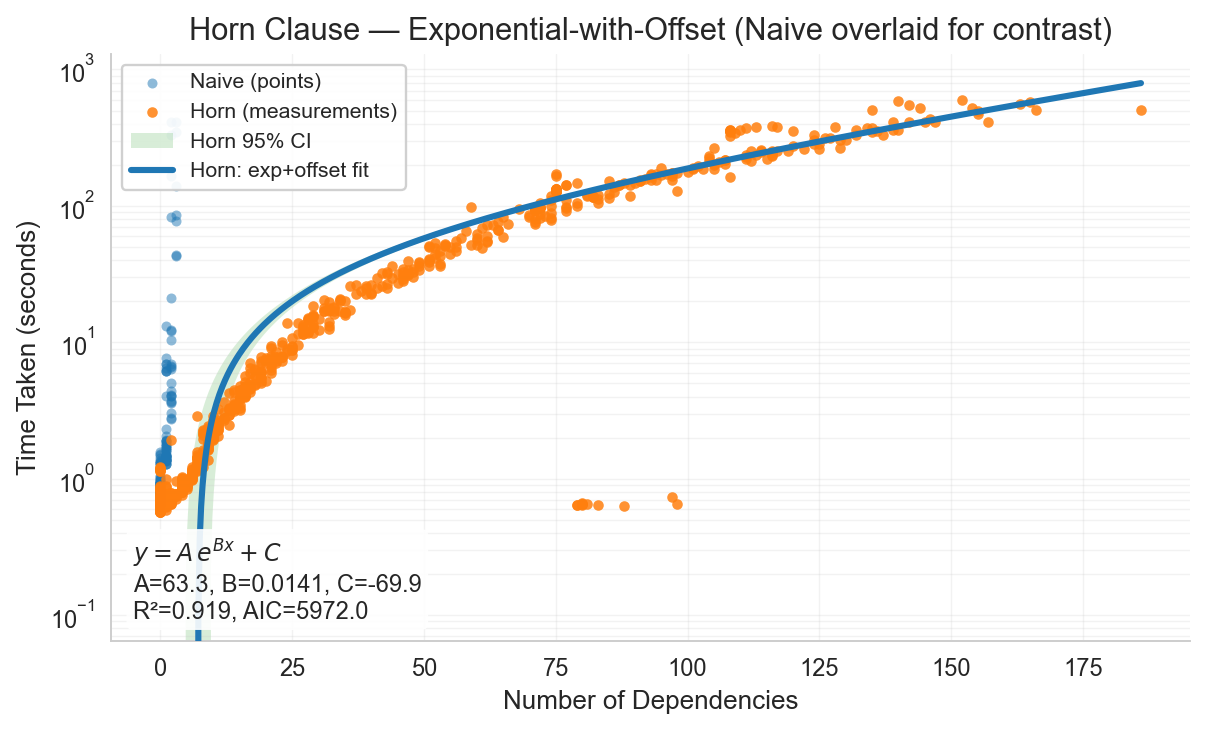

Horn exp+offset: A=63.2721, B=0.0140548, C=-69.8937 | R²=0.919, AIC=5972.0


In [9]:
# Horn exp+offset with Naive points overlaid (paper-ready)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ---------------- Data ----------------
# Horn (heuristic)
xh = df_plot_horn["dependency_count"].to_numpy(float)
yh = df_plot_horn["time_horn_numeric"].to_numpy(float)
mh = np.isfinite(xh) & np.isfinite(yh) & (yh > 0)
xh, yh = xh[mh], yh[mh]
order = np.argsort(xh); xh, yh = xh[order], yh[order]

# Naive (points only; no fit)
xn = df_plot_basic["dependency_count"].to_numpy(float)
yn = df_plot_basic["time_basic_numeric"].to_numpy(float)
mn = np.isfinite(xn) & np.isfinite(yn) & (yn > 0)
xn, yn = xn[mn], yn[mn]

# ---------------- Model & fit ----------------
def f(x, A, B, C):  # y = A * exp(Bx) + C
    return A * np.exp(B * x) + C

spread = np.ptp(yh) if np.isfinite(yh).any() else 1.0
ymin   = float(np.nanmin(yh)) if np.isfinite(yh).any() else 0.0
ymax   = float(np.nanmax(yh)) if np.isfinite(yh).any() else 1.0
p0     = [max(1.0, ymax), 0.01, max(0.0, ymin - 0.1*spread)]
bounds = ([0.0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])

popt, pcov = curve_fit(f, xh, yh, p0=p0, bounds=bounds, maxfev=30000)
A, B, C = popt
yhat = f(xh, *popt)

# metrics
ss_res = np.sum((yh - yhat)**2)
ss_tot = np.sum((yh - yh.mean())**2)
R2     = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
n, k   = yh.size, 3
AIC    = n*np.log(ss_res/n) + 2*k if (n > k and ss_res > 0) else np.nan

# Smooth curve + 95% CI via delta method
x_line = np.linspace(xh.min(), xh.max(), 700)
y_line = f(x_line, *popt)
expBx  = np.exp(B*x_line)
J = np.vstack([expBx, A*x_line*expBx, np.ones_like(x_line)]).T
var_curve = np.einsum("ij,jk,ik->i", J, pcov, J)
se_curve  = np.sqrt(np.maximum(0.0, var_curve))
ci_low, ci_high = y_line - 1.96*se_curve, y_line + 1.96*se_curve

# ---------------- Styling ----------------
mpl.rcParams.update({
    "figure.dpi": 170, "savefig.dpi": 300,
    "font.size": 10, "axes.labelsize": 11, "axes.titlesize": 13,
    "legend.fontsize": 9,
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "axes.spines.top": False, "axes.spines.right": False,
})

fig, ax = plt.subplots(figsize=(7.2, 4.4))

# Naive points (muted so they don't dominate)
ax.scatter(xn, yn, s=18, alpha=0.5, linewidths=0, label="Naive (points)", zorder=1)

# Horn measurements (slightly stronger)
ax.scatter(xh, yh, s=20, alpha=0.85, linewidths=0, label="Horn (measurements)", zorder=2)

# CI band behind the fit
ax.fill_between(x_line, ci_low, ci_high, alpha=0.18, linewidth=0, label="Horn 95% CI", zorder=0)

# Horn fit (on top)
ax.plot(x_line, y_line, linewidth=2.6, label="Horn: exp+offset fit", zorder=3)

# Axis / grid
ax.set_yscale("log")
ax.set_xlabel("Number of Dependencies")
ax.set_ylabel("Time Taken (seconds)")
ax.set_title("Horn Clause — Exponential-with-Offset (Naive overlaid for contrast)")
ax.grid(True, which="both", linewidth=0.6, alpha=0.25)

# Compact legend
ax.legend(frameon=True, fancybox=True, framealpha=0.92, loc="upper left")

# Light annotation with equation & metrics
eq = r"$y = A\,e^{Bx} + C$"
ax.text(0.02, 0.03, f"{eq}\nA={A:.3g}, B={B:.3g}, C={C:.3g}\nR²={R2:.3f}, AIC={AIC:.1f}",
        transform=ax.transAxes, ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.9, lw=0.5))

# Optional: annotate breakdown region for Naive (tweak threshold as you like)
# thresh = np.percentile(xn, 85)  # or a fixed value, e.g., 110
# ax.axvspan(thresh, ax.get_xlim()[1], color="k", alpha=0.05)
# ax.text(thresh, ax.get_ylim()[0]*1.4, "Naive degrades\nat high dependencies",
#         va="bottom", ha="left", fontsize=9)

fig.tight_layout()
# fig.savefig("horn_with_naive_overlay.pdf", bbox_inches="tight")
# fig.savefig("horn_with_naive_overlay.png", bbox_inches="tight")
# fig.savefig("horn_with_naive_overlay.svg", bbox_inches="tight")
plt.show()

print(f"Horn exp+offset: A={A:.6g}, B={B:.6g}, C={C:.6g} | R²={R2:.3f}, AIC={AIC:.1f}")


/var/folders/lq/4jp2ndl57996typyw791t0x00000gn/T/ipykernel_55902/2351452179.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


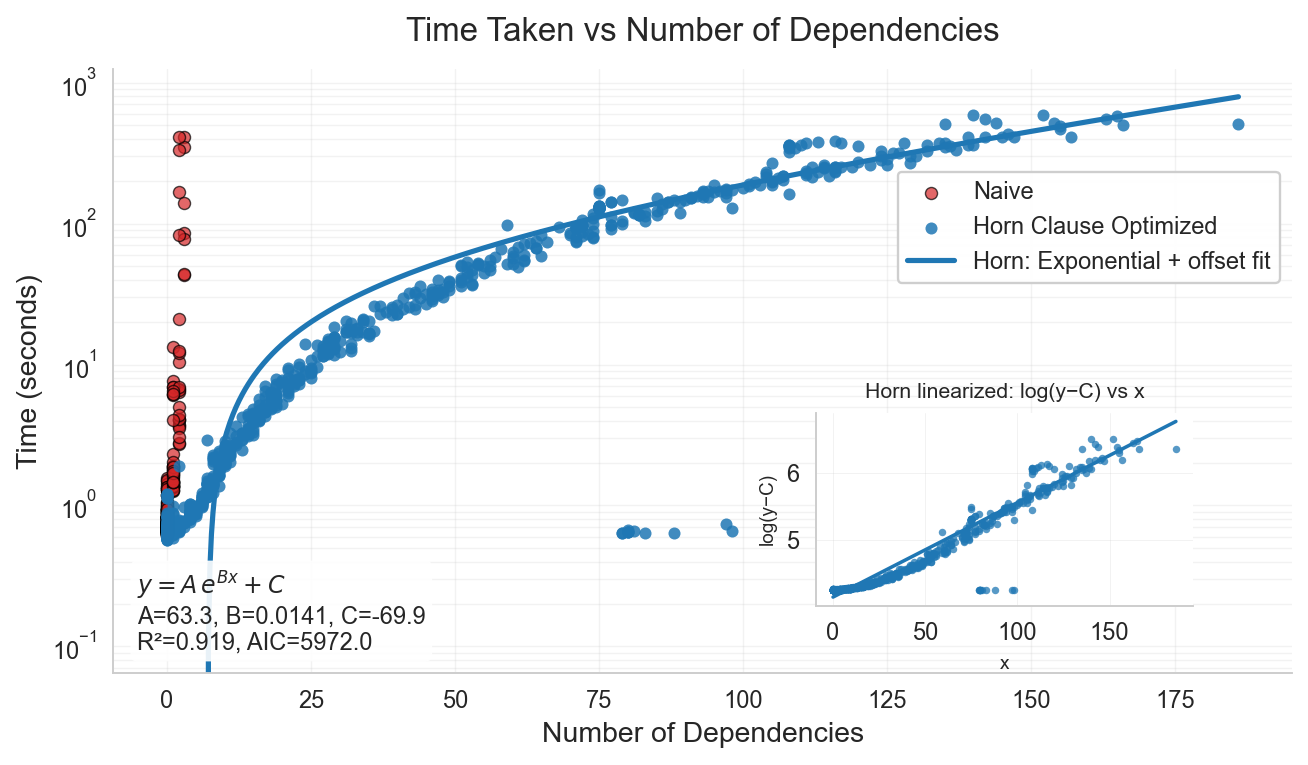

In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

xh = df_plot_horn["dependency_count"].to_numpy(float)
yh = df_plot_horn["time_horn_numeric"].to_numpy(float)
xb = df_plot_basic["dependency_count"].to_numpy(float)
yb = df_plot_basic["time_basic_numeric"].to_numpy(float)

m_h = np.isfinite(xh) & np.isfinite(yh) & (yh > 0)
m_b = np.isfinite(xb) & np.isfinite(yb) & (yb > 0)
xh, yh = xh[m_h], yh[m_h]
xb, yb = xb[m_b], yb[m_b]

order = np.argsort(xh)
xh, yh = xh[order], yh[order]

def f(x, A, B, C):
    return A * np.exp(B*x) + C

spread = np.ptp(yh) if yh.size else 1.0
ymin, ymax = float(yh.min()), float(yh.max())
p0 = [max(1.0, ymax), 0.01, max(0.0, ymin - 0.1*spread)]
bounds = ([0.0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
popt, pcov = curve_fit(f, xh, yh, p0=p0, bounds=bounds, maxfev=30000)
A, B, C = popt

x_line = np.linspace(xh.min(), xh.max(), 700)
y_line = f(x_line, *popt)

mpl.rcParams.update({
    "figure.dpi": 170, "savefig.dpi": 300,
    "font.size": 10, "axes.labelsize": 12, "axes.titlesize": 14,
    "legend.fontsize": 10,
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "axes.spines.top": False, "axes.spines.right": False,
})

fig, ax = plt.subplots(figsize=(7.8, 4.6))

ax.scatter(xb, yb, s=26, alpha=0.7, linewidths=0.6, edgecolors="black",
           label="Naive", color="#d62728")
ax.scatter(xh, yh, s=26, alpha=0.85, linewidths=0.0,
           label="Horn Clause Optimized", color="#1f77b4")

ax.plot(x_line, y_line, linewidth=2.2, label="Horn: Exponential + offset fit", color="#1f77b4" , linestyle="-")

# Axes
ax.set_yscale("log")
ymax_all = float(np.nanmax([yh.max(), yb.max()]))
# ax.set_ylim(1.0, ymax_all * 1.15)   # floor at 1s
ax.set_xlabel("Number of Dependencies")
ax.set_ylabel("Time (seconds)")
ax.set_title("Time Taken vs Number of Dependencies", pad=12)
ax.grid(True, which="both", linewidth=0.6, alpha=0.25)

# Inset: linearized check for Horn
ax_in = inset_axes(ax, width="40%", height="40%", bbox_to_anchor=(0.58, 0.08, 0.80, 0.80), bbox_transform=ax.transAxes, loc="lower left", borderpad=0.8)
mask_lin = (yh - C) > 0
ax_in.scatter(xh[mask_lin], np.log(yh[mask_lin] - C), s=10, alpha=0.75, linewidths=0, color="#1f77b4")
ax_in.plot(x_line, np.log(np.maximum(y_line - C, 1e-12)), lw=1.5, color="#1f77b4")
ax_in.set_title("Horn linearized: log(y−C) vs x", fontsize=9)
ax_in.set_xlabel("x", fontsize=8); ax_in.set_ylabel("log(y−C)", fontsize=8)
ax_in.grid(True, lw=0.4, alpha=0.25)

# Fit metrics (optional box)
ss_res = np.sum((yh - f(xh, *popt))**2)
ss_tot = np.sum((yh - yh.mean())**2)
R2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
n, k = yh.size, 3
AIC = n*np.log(ss_res/n) + 2*k if (n > k and ss_res > 0) else np.nan
eq = r"$y = A\,e^{Bx} + C$"
ax.text(0.02, 0.03, f"{eq}\nA={A:.3g}, B={B:.3g}, C={C:.3g}\nR²={R2:.3f}, AIC={AIC:.1f}",
        transform=ax.transAxes, ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.9, lw=0.5))


# keep legend top outside
# fig.subplots_adjust(top=0.84)  # add headroom for the legend
# ax.legend(
#     loc="upper center",
#     bbox_to_anchor=(0.5, 1.18),  # (x, y) in axes fraction coords
#     ncol=3,
#     frameon=True, fancybox=True, framealpha=0.95
# )


ax.legend(loc="upper right", bbox_to_anchor=(1.0, 0.85), frameon=True, fancybox=True, framealpha=0.95)


fig.tight_layout()
plt.show()


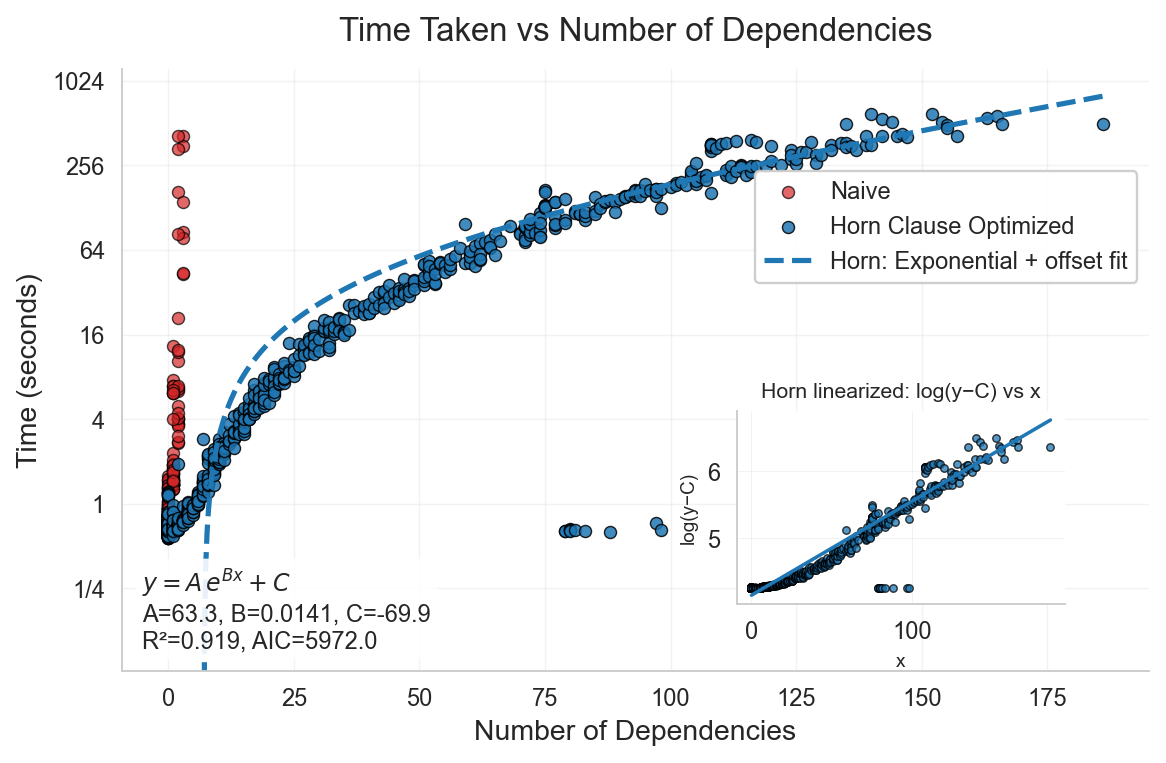

In [11]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter

# =============================
# Style / aesthetics
# =============================
sns.set_style("whitegrid")  # <-- Seaborn background like your 2nd plot
mpl.rcParams.update({
    "figure.dpi": 170, "savefig.dpi": 300,
    "font.size": 10, "axes.labelsize": 12, "axes.titlesize": 14,
    "legend.fontsize": 10,
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "axes.spines.top": False, "axes.spines.right": False,
})

# =============================
# Data (expects your dataframes)
# =============================
xh = df_plot_horn["dependency_count"].to_numpy(float)
yh = df_plot_horn["time_horn_numeric"].to_numpy(float)
xb = df_plot_basic["dependency_count"].to_numpy(float)
yb = df_plot_basic["time_basic_numeric"].to_numpy(float)

m_h = np.isfinite(xh) & np.isfinite(yh) & (yh > 0)
m_b = np.isfinite(xb) & np.isfinite(yb) & (yb > 0)
xh, yh = xh[m_h], yh[m_h]
xb, yb = xb[m_b], yb[m_b]

order = np.argsort(xh)
xh, yh = xh[order], yh[order]

# =============================
# Model & fit: y = A*exp(Bx)+C
# =============================
def f(x, A, B, C):
    return A * np.exp(B*x) + C

spread = np.ptp(yh) if yh.size else 1.0
ymin, ymax = float(yh.min()), float(yh.max())
p0 = [max(1.0, ymax), 0.01, max(0.0, ymin - 0.1*spread)]
bounds = ([0.0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
popt, pcov = curve_fit(f, xh, yh, p0=p0, bounds=bounds, maxfev=30000)
A, B, C = popt

x_line = np.linspace(xh.min(), xh.max(), 700)
y_line = f(x_line, *popt)

# =============================
# Figure
# =============================
fig, ax = plt.subplots(figsize=(7.8, 4.6))

# Points: Naive (red) and Horn (blue) — both with black outlines to match
ax.scatter(xb, yb, s=26, alpha=0.7, linewidths=0.6, edgecolors="black",
           label="Naive", color="#d62728")
ax.scatter(xh, yh, s=26, alpha=0.85, linewidths=0.6, edgecolors="black",
           label="Horn Clause Optimized", color="#1f77b4")

# Fit line (solid or dotted; change linestyle=":" if you want dotted)
ax.plot(x_line, y_line, linewidth=2.2, label="Horn: Exponential + offset fit",
        color="#1f77b4", linestyle="--")

# Axes
ax.set_yscale("log" , base = 2)
ymax_all = float(np.nanmax([yh.max(), yb.max()]))
ax.yaxis.set_major_formatter(FuncFormatter(
    lambda v, pos: f"{int(v)}" if v >= 1 else f"1/{int(round(1/v))}"
))
# Uncomment to avoid sub-second ticks: floor y at 1s
# ax.set_ylim(1.0, ymax_all * 1.15)
ax.set_xlabel("Number of Dependencies")
ax.set_ylabel("Time (seconds)")
ax.set_title("Time Taken vs Number of Dependencies", pad=12)
ax.grid(True, which="both", linewidth=0.6, alpha=0.25)

# Inset: linearized check for Horn
# Using percentage width/height -> bbox_to_anchor must be a 4-tuple (x0, y0, w, h)
ax_in = inset_axes(
    ax, width="40%", height="40%",
    bbox_to_anchor=(0.58, 0.08, 0.80, 0.80),
    bbox_transform=ax.transAxes,
    loc="lower left", borderpad=0.8
)
mask_lin = (yh - C) > 0
ax_in.scatter(xh[mask_lin], np.log(yh[mask_lin] - C), s=10, alpha=0.75,
              linewidths=0.6, edgecolors="black", color="#1f77b4")
ax_in.plot(x_line, np.log(np.maximum(y_line - C, 1e-12)), lw=1.5, color="#1f77b4")
ax_in.set_title("Horn linearized: log(y−C) vs x", fontsize=9)
ax_in.set_xlabel("x", fontsize=8); ax_in.set_ylabel("log(y−C)", fontsize=8)
ax_in.grid(True, lw=0.4, alpha=0.25)

# Fit metrics (optional box)
ss_res = np.sum((yh - f(xh, *popt))**2)
ss_tot = np.sum((yh - yh.mean())**2)
R2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
n, k = yh.size, 3
AIC = n*np.log(ss_res/n) + 2*k if (n > k and ss_res > 0) else np.nan
eq = r"$y = A\,e^{Bx} + C$"
ax.text(0.02, 0.03, f"{eq}\nA={A:.3g}, B={B:.3g}, C={C:.3g}\nR²={R2:.3f}, AIC={AIC:.1f}",
        transform=ax.transAxes, ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.9, lw=0.5))

# Legend (inside, upper-right but nudged down a bit)
ax.legend(loc="upper right", bbox_to_anchor=(1.0, 0.85),
          frameon=True, fancybox=True, framealpha=0.95)

plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter_exponential_2.1.pdf", bbox_inches="tight")

# fig.tight_layout()
plt.show()


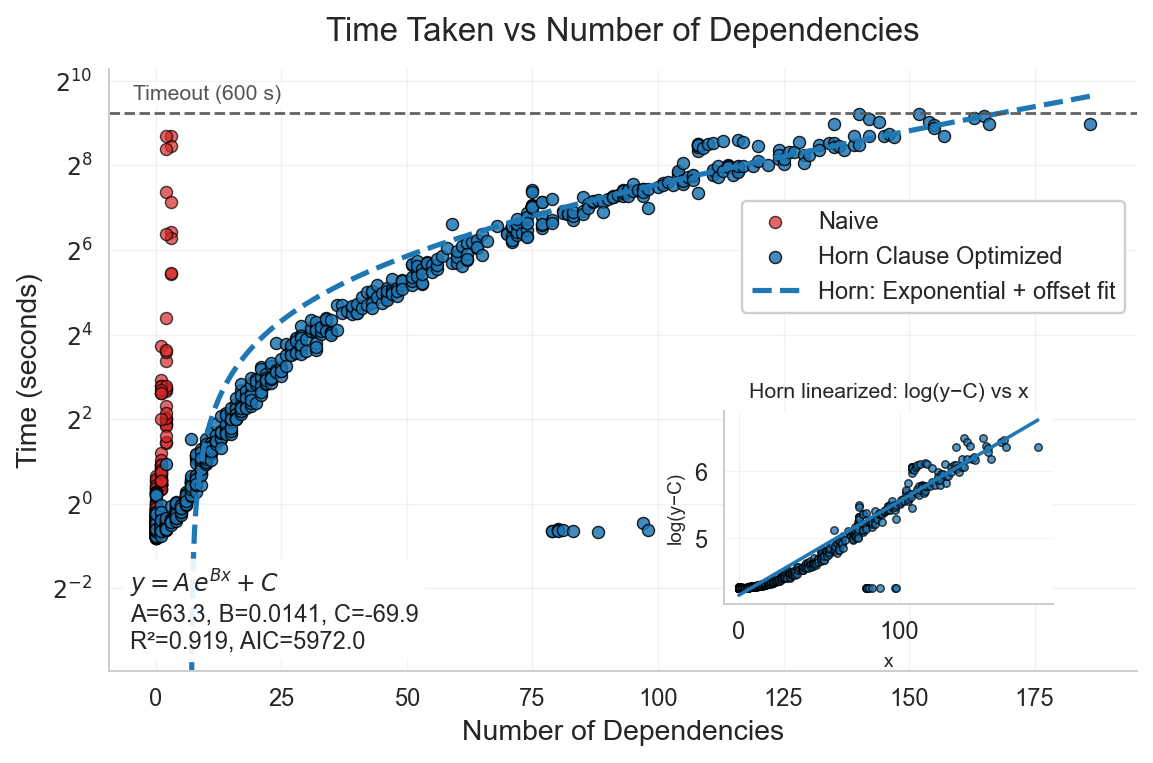

In [67]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter

# =============================
# Style / aesthetics
# =============================
sns.set_style("whitegrid")
mpl.rcParams.update({
    "figure.dpi": 170, "savefig.dpi": 300,
    "font.size": 10, "axes.labelsize": 12, "axes.titlesize": 14,
    "legend.fontsize": 10,
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "axes.spines.top": False, "axes.spines.right": False,
})

# =============================
# Data
# =============================
xh = df_plot_horn["dependency_count"].to_numpy(float)
yh = df_plot_horn["time_horn_numeric"].to_numpy(float)
xb = df_plot_basic["dependency_count"].to_numpy(float)
yb = df_plot_basic["time_basic_numeric"].to_numpy(float)

m_h = np.isfinite(xh) & np.isfinite(yh) & (yh > 0)
m_b = np.isfinite(xb) & np.isfinite(yb) & (yb > 0)
xh, yh = xh[m_h], yh[m_h]
xb, yb = xb[m_b], yb[m_b]

order = np.argsort(xh)
xh, yh = xh[order], yh[order]

# =============================
# Model & fit: y = A*exp(Bx)+C
# =============================
def f(x, A, B, C): return A * np.exp(B*x) + C

spread = np.ptp(yh) if yh.size else 1.0
ymin, ymax = float(yh.min()), float(yh.max())
p0 = [max(1.0, ymax), 0.01, max(0.0, ymin - 0.1*spread)]
bounds = ([0.0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
popt, pcov = curve_fit(f, xh, yh, p0=p0, bounds=bounds, maxfev=30000)
A, B, C = popt

x_line = np.linspace(xh.min(), xh.max(), 700)
y_line = f(x_line, *popt)

# =============================
# Figure
# =============================
fig, ax = plt.subplots(figsize=(7.8, 4.6))

# Points: Naive (red) and Horn (blue) — both with black outlines
ax.scatter(xb, yb, s=26, alpha=0.7, linewidths=0.6, edgecolors="black",
           label="Naive", color="#d62728")
ax.scatter(xh, yh, s=26, alpha=0.85, linewidths=0.6, edgecolors="black",
           label="Horn Clause Optimized", color="#1f77b4")

# Fit line — dashed
ax.plot(x_line, y_line, linewidth=2.2, label="Horn: Exponential + offset fit",
        color="#1f77b4", linestyle="--")

# Axes: log2 with 2^k labels (no manual tick setting)
ax.set_yscale("log", base=2)
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, p: rf"$2^{{{int(np.log2(v))}}}$"))

# Optional timeout reference line
ax.axhline(600, linestyle="--", linewidth=1.2, color="#555555", alpha=0.9)
ax.annotate("Timeout (600 s)", xy=(0.01, 600), xycoords=("axes fraction", "data"),
            xytext=(6, 4), textcoords="offset points", fontsize=9, color="#555555",
            ha="left", va="bottom",
            bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.8))

# Labels / title / grid
ax.set_xlabel("Number of Dependencies")
ax.set_ylabel("Time (seconds)")
ax.set_title("Time Taken vs Number of Dependencies", pad=12)
ax.grid(True, which="both", linewidth=0.6, alpha=0.25)

# Inset: linearized check for Horn
ax_in = inset_axes(
    ax, width="40%", height="40%",
    bbox_to_anchor=(0.58, 0.08, 0.80, 0.80),  # (x0, y0, w, h) in axes fraction
    bbox_transform=ax.transAxes,
    loc="lower left", borderpad=0.8
)
mask_lin = (yh - C) > 0
ax_in.scatter(xh[mask_lin], np.log(yh[mask_lin] - C), s=10, alpha=0.75,
              linewidths=0.6, edgecolors="black", color="#1f77b4")
ax_in.plot(x_line, np.log(np.maximum(y_line - C, 1e-12)), lw=1.5, color="#1f77b4")
ax_in.set_title("Horn linearized: log(y−C) vs x", fontsize=9)
ax_in.set_xlabel("x", fontsize=8); ax_in.set_ylabel("log(y−C)", fontsize=8)
ax_in.grid(True, lw=0.4, alpha=0.25)

# Fit metrics (optional)
ss_res = np.sum((yh - f(xh, *popt))**2)
ss_tot = np.sum((yh - yh.mean())**2)
R2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
n, k = yh.size, 3
AIC = n*np.log(ss_res/n) + 2*k if (n > k and ss_res > 0) else np.nan
eq = r"$y = A\,e^{Bx} + C$"
ax.text(0.02, 0.03, f"{eq}\nA={A:.3g}, B={B:.3g}, C={C:.3g}\nR²={R2:.3f}, AIC={AIC:.1f}",
        transform=ax.transAxes, ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.9, lw=0.5))

# Legend (inside, upper-right, nudged down)
ax.legend(loc="upper right", bbox_to_anchor=(1.0, 0.80),
          frameon=True, fancybox=True, framealpha=0.95)

# Save / show
# plt.savefig("scatter_exponential_log2_powlabels.pdf", bbox_inches="tight")
plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter_exponential_2_timeout.pdf", bbox_inches="tight")
plt.show()


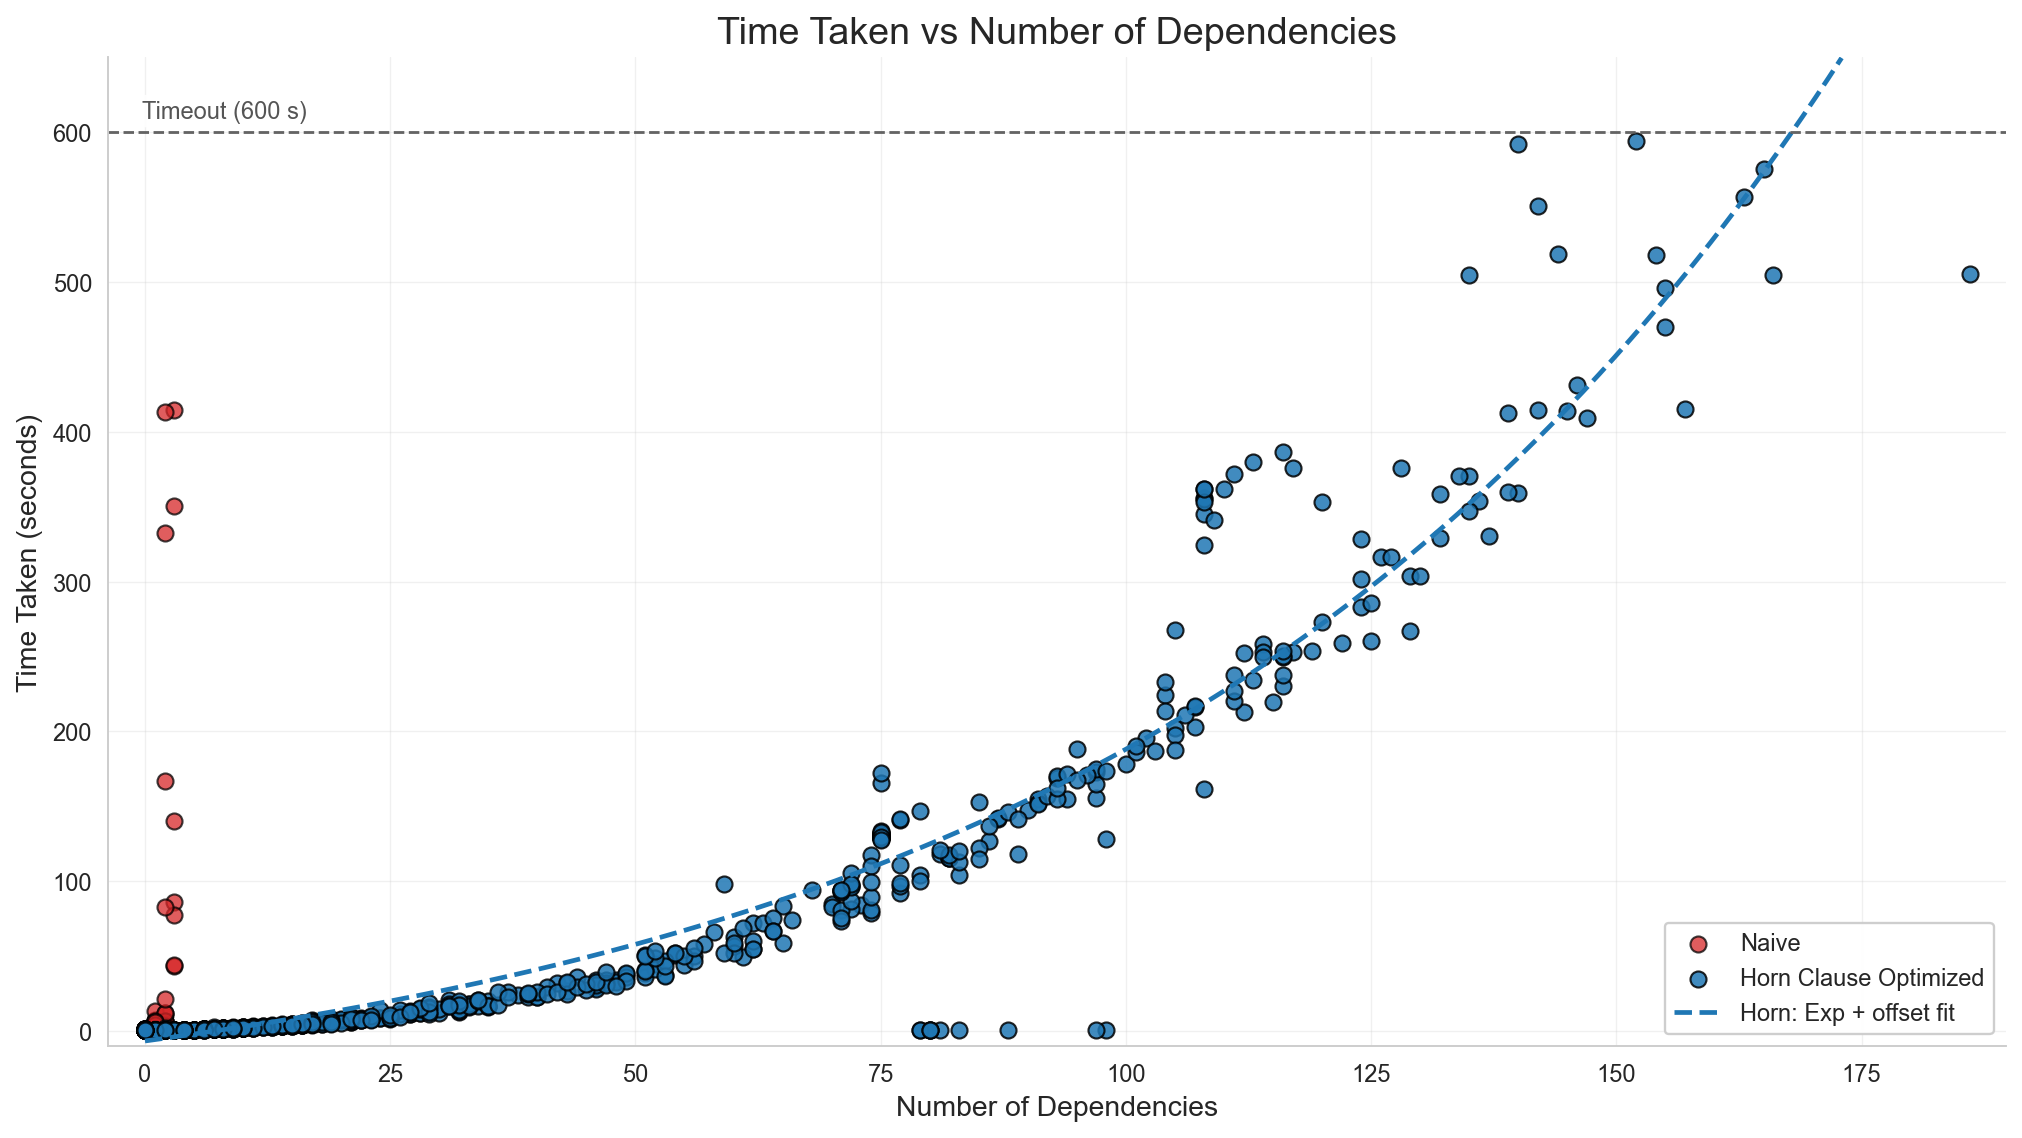

In [12]:
# ---------- Focused plot WITH exponential fit ----------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit

TIMEOUT = 600.0
Y_CAP   = 650.0
POINT_S = 46

def f(x, A, B, C):
    return A * np.exp(B * x) + C

# --- Fit on Horn data (finite & >0) ---
xh = df_plot_horn["dependency_count"].to_numpy(float)
yh = df_plot_horn["time_horn_numeric"].to_numpy(float)
m_fit = np.isfinite(xh) & np.isfinite(yh) & (yh > 0)
xh_fit, yh_fit = xh[m_fit], yh[m_fit]

fit_ok = False
if yh_fit.size >= 3:
    order = np.argsort(xh_fit)
    xh_fit, yh_fit = xh_fit[order], yh_fit[order]
    spread = np.ptp(yh_fit) if yh_fit.size else 1.0
    ymin, ymax = float(yh_fit.min()), float(yh_fit.max())
    p0 = [max(1.0, ymax), 0.01, max(0.0, ymin - 0.1*spread)]
    bounds = ([0.0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])

    popt, pcov = curve_fit(f, xh_fit, yh_fit, p0=p0, bounds=bounds, maxfev=30000)
    A, B, C = popt
    # smooth curve
    x_line = np.linspace(xh_fit.min(), xh_fit.max(), 700)
    y_line = f(x_line, *popt)

    # metrics
    ss_res = np.sum((yh_fit - f(xh_fit, *popt))**2)
    ss_tot = np.sum((yh_fit - yh_fit.mean())**2)
    R2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    fit_ok = True

sns.set_style("whitegrid")
mpl.rcParams.update({
    "figure.dpi": 170, "savefig.dpi": 300,
    "font.size": 10, "axes.labelsize": 12, "axes.titlesize": 16,
    "legend.fontsize": 10,
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "axes.spines.top": False, "axes.spines.right": False,
})

fig, ax = plt.subplots(figsize=(12.0, 6.8))

# --- Points ---
ax.scatter(
    df_plot_basic["dependency_count"], df_plot_basic["time_basic_numeric"],
    color="#d62728", alpha=0.75, marker="o",
    edgecolors="black", linewidths=0.9, s=POINT_S, label="Naive"
)
ax.scatter(
    df_plot_horn["dependency_count"], df_plot_horn["time_horn_numeric"],
    color="#1f77b4", alpha=0.85, marker="o",
    edgecolors="black", linewidths=0.9, s=POINT_S, label="Horn Clause Optimized"
)

# --- Fit line (dashed blue), clipped at Y_CAP to keep the clean focus ---
if fit_ok:
    m_cap = y_line <= Y_CAP
    if not m_cap.all():
        idx = np.argmax(~m_cap)  # first point above cap
        x_seg, y_seg = x_line[:idx], y_line[:idx]
    else:
        x_seg, y_seg = x_line, y_line
    ax.plot(x_seg, y_seg, linestyle="--", linewidth=2.0, color="#1f77b4",
            label="Horn: Exp + offset fit")

# --- Timeout line ---
ax.axhline(TIMEOUT, linestyle="--", linewidth=1.2, color="#555555", alpha=0.9)
ax.annotate("Timeout (600 s)", xy=(0.01, TIMEOUT), xycoords=("axes fraction", "data"),
            xytext=(6, 4), textcoords="offset points", fontsize=10, color="#555555",
            ha="left", va="bottom",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.9))

# --- Labels / title ---
ax.set_xlabel("Number of Dependencies")
ax.set_ylabel("Time Taken (seconds)")
ax.set_title("Time Taken vs Number of Dependencies")

# =========================
# REPLACED Y-FRAME SECTION (adds padding below 0)
# =========================
LOWER_PAD_FRAC = 0.06    # increase for more space under points
LOWER_FLOOR    = -10.0   # don’t go below this

y_all = np.concatenate([
    df_plot_basic["time_basic_numeric"].to_numpy(float),
    df_plot_horn["time_horn_numeric"].to_numpy(float)
])
y_all = y_all[np.isfinite(y_all) & (y_all >= 0)]
y_lo  = np.percentile(y_all, 0.5) if y_all.size else 0.0
margin = LOWER_PAD_FRAC * (Y_CAP - y_lo)
y_min  = max(LOWER_FLOOR, y_lo - margin)

ax.set_ylim(y_min, Y_CAP)

# x-range tight to data
x_all = np.concatenate([
    df_plot_basic["dependency_count"].to_numpy(float),
    df_plot_horn["dependency_count"].to_numpy(float)
])
x_all = x_all[np.isfinite(x_all)]
x_min, x_max = (x_all.min(), x_all.max()) if x_all.size else (0, 1)
x_pad = 0.02 * (x_max - x_min if x_max > x_min else 1)
ax.set_xlim(x_min - x_pad, x_max + x_pad)

# --- Minimal metrics box (compact, near upper-left) ---
# if fit_ok and np.isfinite(R2):
#     trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
#     ax.text(
#         0.02, TIMEOUT - 30,
#         f"$y=Ae^{{Bx}}+C$\nA={A:.3g}, B={B:.3g}, C={C:.3g}\nR²={R2:.3f}",
#         transform=trans, ha="left", va="top",
#         bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.95, lw=0.6)
#     )

# --- Final touches ---
ax.grid(True, which="both", linewidth=0.6, alpha=0.28)
ax.legend(loc="lower right", frameon=True, fancybox=True, framealpha=0.95)

plt.tight_layout()
# plt.savefig("scatter_focused_with_fit.pdf", bbox_inches="tight")
plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter_exponential_nolog.pdf", bbox_inches="tight")
plt.show()


JSON decode error in file serde-big-array-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 203)
JSON decode error in file markdown-0.3.0.json: Expecting property name enclosed in double quotes: line 11 column 1 (char 203)
JSON decode error in file mio-extras-2.0.6.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pipeline-0.5.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file glsl-layout-derive-0.4.0.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 207)
JSON decode error in file lzma-sys-0.1.20.json: Expecting property name enclosed in double quotes: line 32 column 1 (char 601)
JSON decode error in file fail-0.5.1.json: Expecting property name enclosed in double quotes: line 12 column 1 (char 206)
JSON decode error in file pickledb-0.5.1.json: Expecting property name enclosed in double quotes: line

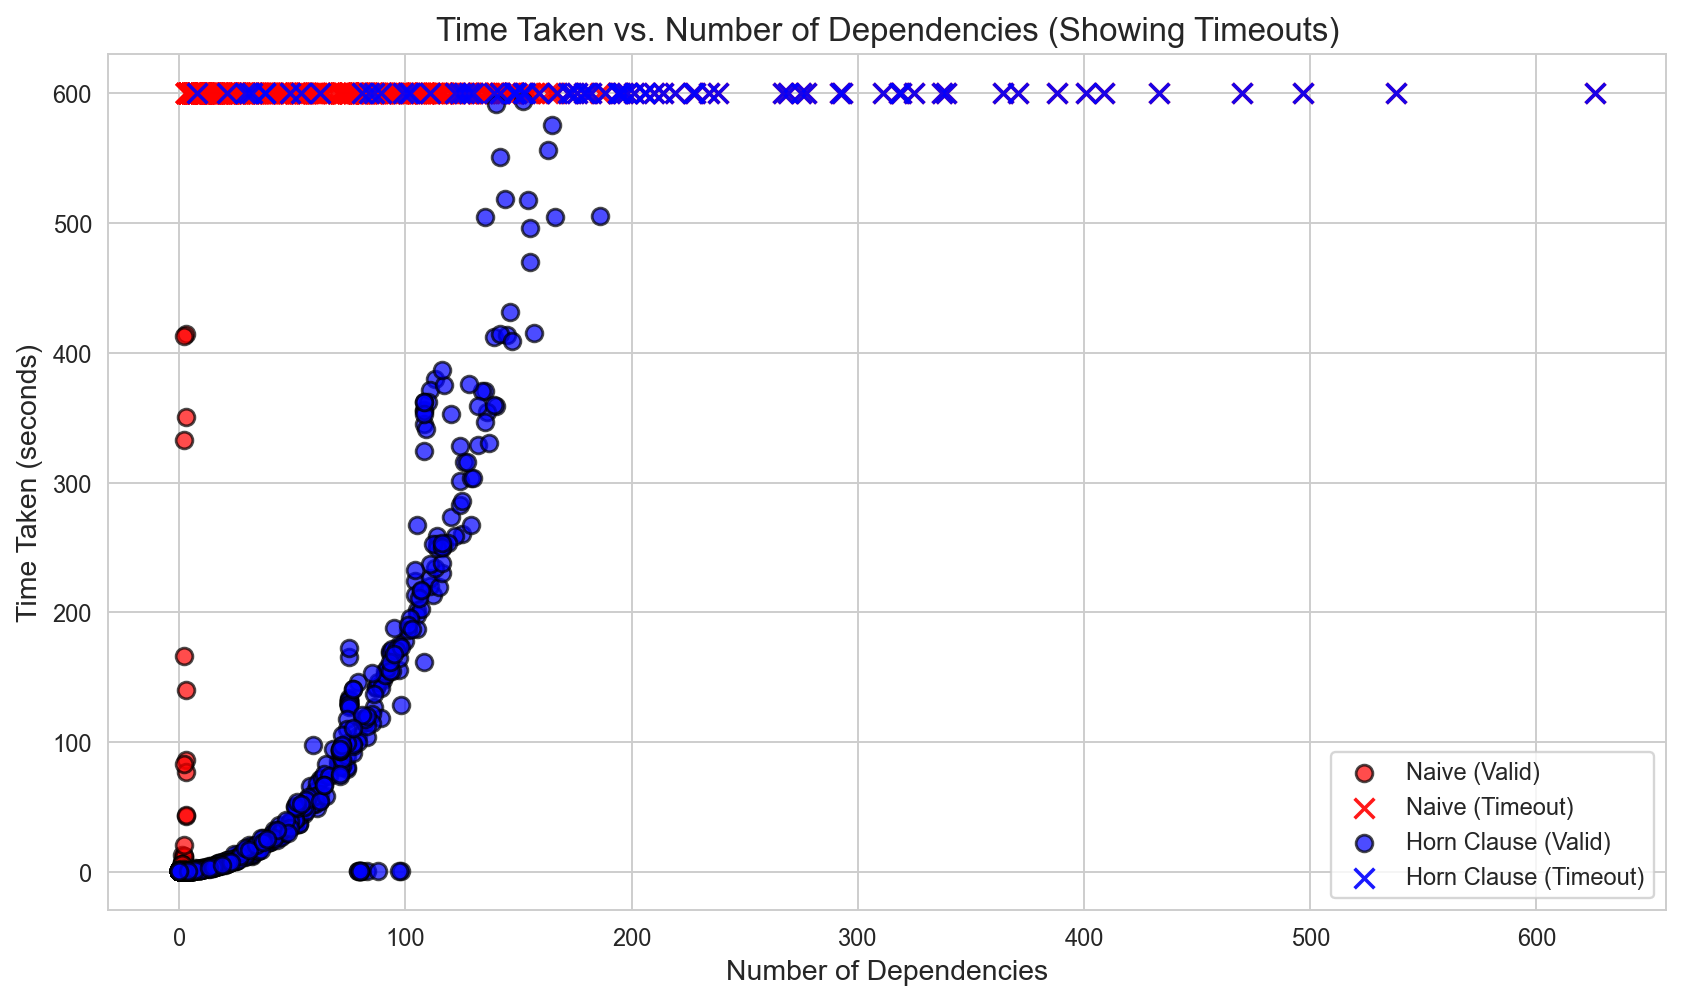

In [13]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------------------
# 1. Parse JSON files for dependency counts
# ----------------------------------------------------------------------
CACHE_DIR = "logs/cache"  # Adjust path if needed
rows = []
failed_files = []  # List to hold names of JSON files that failed to parse

for filename in os.listdir(CACHE_DIR):
    if not filename.endswith(".json"):
        continue  # Skip non-JSON files
    path = os.path.join(CACHE_DIR, filename)
    
    # Assume filename format: "crate_name-version.json"
    base = filename[:-5]  # Remove ".json"
    if "-" in base:
        crate_name, crate_version = base.rsplit("-", 1)
    else:
        crate_name = base
        crate_version = "0.0.0"
    
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"JSON decode error in file {filename}: {e}")
        failed_files.append(filename)
        continue  # Skip this file
    
    # Get the dependency list and count them
    deps = data.get("dependencies", [])
    dep_count = len(deps)
    
    rows.append({
        "crate_name": crate_name,
        "version": crate_version,
        "dependency_count": dep_count
    })

df_deps = pd.DataFrame(rows)
print("Dependency counts extracted:")
print(df_deps.head())
if failed_files:
    print("The following files failed to parse and were skipped:")
    for f in failed_files:
        print(f)

# ----------------------------------------------------------------------
# 2. Read timing CSV files for two algorithms (with possible "timeout" values)
# ----------------------------------------------------------------------
df_basic = pd.read_csv("execution_timebasic_timeout.csv", dtype=str)
df_basic = df_basic.rename(columns={"time_taken": "time_basic"})

df_horn = pd.read_csv("execution_timeHorn_timeout.csv", dtype=str)
df_horn = df_horn.rename(columns={"time_taken": "time_horn"})

# ----------------------------------------------------------------------
# 3. Merge timing data and dependency counts
# ----------------------------------------------------------------------
df_times = pd.merge(df_basic, df_horn, on=["crate_name", "version"], how="outer")
df_merged = pd.merge(df_times, df_deps, on=["crate_name", "version"], how="left")

# Optional: save merged data
df_merged.to_csv("data_with_deps_and_times_new.csv", index=False)
print("Merged data saved to data_with_deps_and_times_new.csv")
print(df_merged.head())

# ----------------------------------------------------------------------
# 4. Define helpers to check file line counts and determine timeouts
# ----------------------------------------------------------------------
NAIVE_DIR = "evaluation/rq4"             # Directory for Naive approach files
HORN_DIR = os.path.join("evaluation", "rq3", "random1000")  # Directory for Horn Clause files

def file_line_count(directory, crate_name, version):
    """
    Returns the number of lines in the corresponding file, or 0 if file does not exist.
    """
    filename = f"{crate_name}-{version}"
    file_path = os.path.join(directory, filename)
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            return len(f.readlines())
    return 0

def is_naive_timeout(row):
    """
    Determines if the Naive approach (time_basic) is a timeout.
    Conditions for timeout:
    1) CSV says "timeout", OR
    2) The file in NAIVE_DIR does not exist or has <= 1 line
    """
    if str(row["time_basic"]).strip().lower() == "timeout":
        return True
    
    line_count = file_line_count(NAIVE_DIR, row["crate_name"], row["version"])
    if line_count <= 1:
        return True
    
    # If numeric, check for any other custom condition if needed
    # Otherwise, not a timeout
    return False

def is_horn_timeout(row):
    """
    Determines if the Horn approach (time_horn) is a timeout.
    Conditions for timeout:
    1) CSV says "timeout", OR
    2) The file in HORN_DIR does not exist or has <= 1 line
    """
    if str(row["time_horn"]).strip().lower() == "timeout":
        return True
    
    line_count = file_line_count(HORN_DIR, row["crate_name"], row["version"])
    if line_count <= 1:
        return True
    
    return False

# ----------------------------------------------------------------------
# 5. Apply the timeout checks and create numeric columns for valid times
# ----------------------------------------------------------------------
df_merged["naive_timeout"] = df_merged.apply(is_naive_timeout, axis=1)
df_merged["horn_timeout"]  = df_merged.apply(is_horn_timeout,  axis=1)

# Convert valid times to numeric, turn anything else into NaN
df_merged["time_basic_numeric"] = pd.to_numeric(df_merged["time_basic"], errors='coerce')
df_merged["time_horn_numeric"]  = pd.to_numeric(df_merged["time_horn"],  errors='coerce')

# For plotting, assign a fixed value (e.g., 600) to timeouts
TIMEOUT_VALUE = 600
df_merged["time_basic_plot"] = np.where(df_merged["naive_timeout"],
                                        TIMEOUT_VALUE,
                                        df_merged["time_basic_numeric"])
df_merged["time_horn_plot"] = np.where(df_merged["horn_timeout"],
                                       TIMEOUT_VALUE,
                                       df_merged["time_horn_numeric"])

# ----------------------------------------------------------------------
# 6. Split into subsets for plotting
# ----------------------------------------------------------------------
# Naive approach:
df_naive_valid   = df_merged[~df_merged["naive_timeout"] & df_merged["time_basic_numeric"].notna()].copy()
df_naive_timeout = df_merged[df_merged["naive_timeout"]].copy()

# Horn approach:
df_horn_valid   = df_merged[~df_merged["horn_timeout"] & df_merged["time_horn_numeric"].notna()].copy()
df_horn_timeout = df_merged[df_merged["horn_timeout"]].copy()

# ----------------------------------------------------------------------
# 7. Plot: Show timeouts as crosses, valid times as circles
# ----------------------------------------------------------------------
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,6))

# Naive valid (red circles)
ax.scatter(
    df_naive_valid["dependency_count"],
    df_naive_valid["time_basic_numeric"],
    color="red",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Naive (Valid)"
)

# Naive timeout (red crosses)
ax.scatter(
    df_naive_timeout["dependency_count"],
    df_naive_timeout["time_basic_plot"],
    color="red",
    alpha=0.9,
    marker="x",
    s=70,
    label="Naive (Timeout)"
)

# Horn valid (blue circles)
ax.scatter(
    df_horn_valid["dependency_count"],
    df_horn_valid["time_horn_numeric"],
    color="blue",
    alpha=0.7,
    marker="o",
    edgecolors="black",
    linewidths=1.2,
    s=50,
    label="Horn Clause (Valid)"
)

# Horn timeout (blue crosses)
ax.scatter(
    df_horn_timeout["dependency_count"],
    df_horn_timeout["time_horn_plot"],
    color="blue",
    alpha=0.9,
    marker="x",
    s=70,
    label="Horn Clause (Timeout)"
)

ax.set_xlabel("Number of Dependencies", fontsize=12)
ax.set_ylabel("Time Taken (seconds)", fontsize=12)
ax.set_title("Time Taken vs. Number of Dependencies (Showing Timeouts)", fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig("/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq4/scatter_new.pdf", bbox_inches="tight")
plt.show()
